In [2]:
import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pickle
import os 
from config import TWITTER_DATA_DIR

%load_ext autoreload
%autoreload 2

In [3]:
campaigns = preprocessing.load_campaign()
users = preprocessing.load_user_data()

In [10]:
is_template = lambda x: not x.root.template == ''
template_cascades = preprocessing.process_campaign(campaigns,
                                                   filter_func=is_template)

100%|██████████| 75/75 [00:28<00:00,  2.67it/s]


In [11]:
is_not_template = lambda x: x.root.template == ''
not_template_cascades = preprocessing.process_campaign(campaigns,
                                                       filter_func=is_not_template)

100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Text(0, 0.5, '# of cascades')

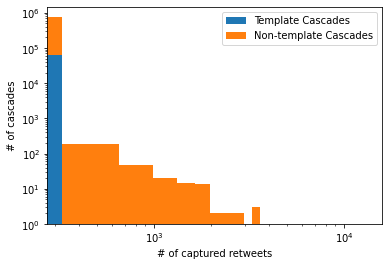

In [101]:
temp = [x.n_retweets for x in template_cascades]
no_temp = [x.n_retweets for x in not_template_cascades]

plt.hist([temp, no_temp], bins=40, stacked=True, density=False, log=False, label=['Template Cascades', 
                                                                                 'Non-template Cascades'])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('# of captured retweets')
plt.ylabel('# of cascades')

(array([6.3253e+04, 3.7000e+01, 1.1000e+01, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,   42.4,   84.8,  127.2,  169.6,  212. ,  254.4,  296.8,
         339.2,  381.6,  424. ,  466.4,  508.8,  551.2,  593.6,  636. ,
         678.4,  720.8,  763.2,  805.6,  848. ,  890.4,  932.8,  975.2,
        1017.6, 1060. , 1102.4, 1144.8, 1187.2, 1229.6, 1272. ]),
 <BarContainer object of 30 artists>)

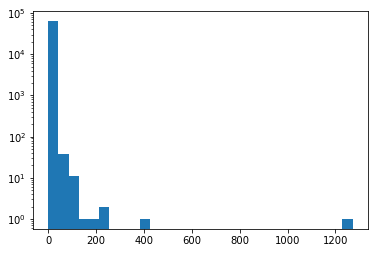

In [68]:
plt.hist([x.n_retweets for x in template_cascades], bins=30, log=True)

(array([7.03575e+05, 1.20000e+02, 3.70000e+01, 1.90000e+01, 1.20000e+01,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0.        ,   437.83333333,   875.66666667,  1313.5       ,
         1751.33333333,  2189.16666667,  2627.        ,  3064.83333333,
         3502.66666667,  3940.5       ,  4378.33333333,  4816.16666667,
         5254.        ,  5691.83333333,  6129.66666667,  6567.5       ,
         7005.33333333,  7443.16666667,  7881.        ,  8318.83333333,
         8756.66666667,  9194.5       ,  9632.33333333, 10070.16666667,
        10508.        , 10945.83333333, 11383.66666667, 11821.5       ,
        12259.33333333, 12697.16666667, 13135.        ])

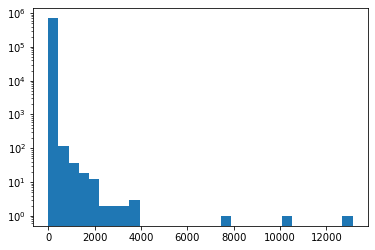

In [56]:
plt.hist([x.n_retweets for x in not_template_cascades], bins=30, log=True)

## Do Templated Tweets Spread to Others?
- Examine users on templated tweets
- Examine % non participant per cascade

In [12]:
def get_tweets_and_rt_counts_for_cascades(cascade_list, weighted=True, size_thresh=0):
    # takes list of cascades
    # weighted: if true, each tweet gets the value of its implied RTs, else 1 
    # size: min out degree of a node to be included
    res_dict = defaultdict(list)
    for t_list in tqdm([x.get_top_tweets(thresh=size_thresh) for x in cascade_list]):
        for t, rt_count in t_list:
            user_type = users.type.get(t.username, 'Unknown')
            val = rt_count if weighted else 1
            res_dict[user_type].append(val)
    return res_dict

In [ ]:
res_dict = get_all_tweets_and_rt_counts_for_cascades(template_cascades)

Text(0.5, 1.0, 'User distribution by # of RTs for templated tweets')

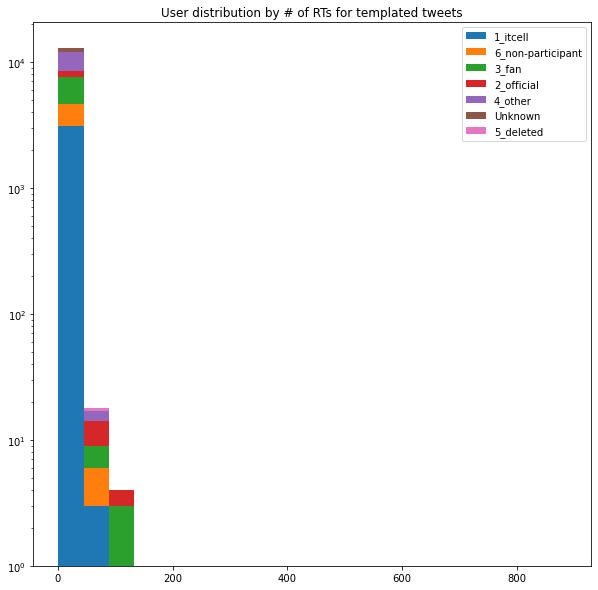

In [92]:
keys, values = res_dict.keys(), res_dict.values()
plt.figure(figsize=(10,10))
x = plt.hist(values, stacked=True, label=list(keys), bins=20, log=True)
plt.legend()
plt.title('User distribution by # of RTs for templated tweets')

In [128]:
def normalize_cascade(li, weighted=True):
    # takes list of (tweet, rt_count) and 
    ans = defaultdict(int)
    tot = 0
    for t, rt_c in li:
        user_type = users.type.get(t.username, 'Unknown')
        ans[user_type] += rt_c if weighted else 1
        tot += rt_c
    return {k: v/tot for k,v in ans.items()} #normalize

In [121]:
norm_cascades = [normalize_cascade(x) for x in template_cascade_tweets if len(x) > 0]
total_sizes = [len(x) for x in template_cascade_tweets if len(x) > 0]

In [ ]:
rt_ratios = [normalize_cascade(x) for x in template_cascade_tweets if len(x) > 0]

In [129]:
norm_cascades_by_rts = [normalize_cascade(x, weighted=False) for x in template_cascade_tweets if len(x) > 0]
non_participant_rts =  [x.get('6_non-participant', 0) for x in norm_cascades_by_rts]

In [122]:
non_participant_percents = [x.get('6_non-participant', 0) for x in norm_cascades]

Text(0, 0.5, '% of RTs produced by non-participants')

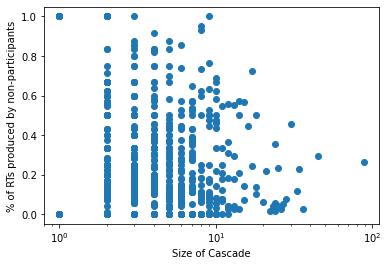

In [134]:
plt.scatter(total_sizes, non_participant_percents)
plt.xscale('log')
plt.xlabel('Size of Cascade')
plt.ylabel('% of RTs produced by non-participants')

Text(0, 0.5, '% of RTs made by non-participants')

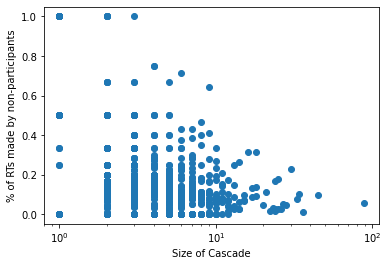

In [135]:
plt.scatter(total_sizes, non_participant_rts)
plt.xscale('log')
plt.xlabel('Size of Cascade')
plt.ylabel('% of RTs made by non-participants')

(array([5887.,  163.,  191.,  111.,   45.,  139.,   38.,   11.,   14.,
          98.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

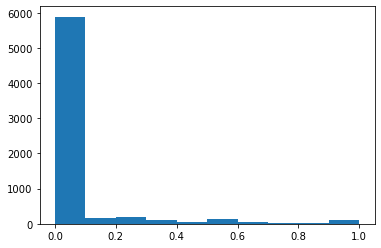

In [120]:
plt.hist([x.get('6_non-participant', 0) for x in norm_cascades])

# Examining IT Cell Penetration in non template cascades
To this point, I've been looking at the cascades that started as templates. Let's look at the bigger ones, and the role IT cell peeps play in them

In [13]:
res_dict = get_all_tweets_and_rt_counts_for_cascades(not_template_cascades)

In [16]:
with open(os.path.join(TWITTER_DATA_DIR, 'non_template_cascade_tweets_with_rt_counts.pkl'), 'wb') as f:
    pickle.dump(res_dict, f)

Text(0.5, 1.0, 'User distribution by # of RTs for non-templated tweets')

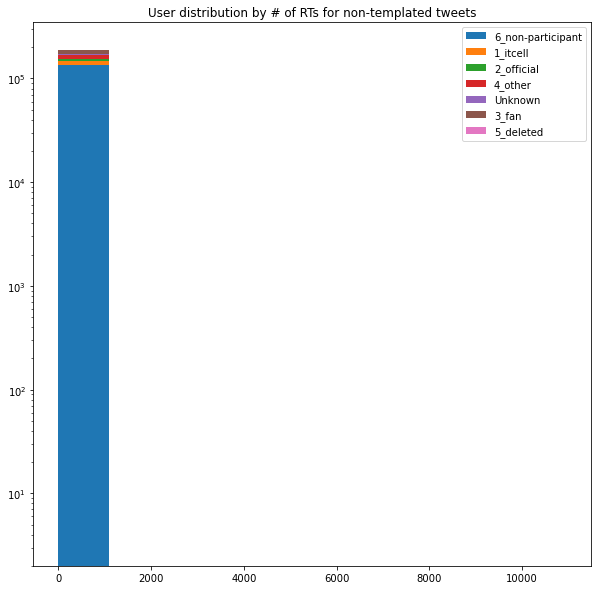

In [19]:
keys, values = res_dict.keys(), res_dict.values()
plt.figure(figsize=(10,10))
x = plt.hist(values, stacked=True, label=list(keys), bins=10, log=True)
plt.legend()
plt.title('User distribution by # of RTs for non-templated tweets')

# Examining Cascades and Who Starts Them When its not a template

In [91]:
none_to_zero = lambda x: 0 if x is None else x
temp = [(users.type.get(c.root.username, 'Unknown'), none_to_zero(c.root.retweets)) 
        for c in not_template_cascades if none_to_zero(c.root.retweets) > 100]

In [92]:
res = defaultdict(list)
for user_type, n in temp:
    res[user_type].append(n)

In [93]:
def stacked_hist(res_dict, **kwargs):
    keys, values = res_dict.keys(), res_dict.values()
    x = plt.hist(values, stacked=True, label=list(keys), **kwargs)
    plt.legend()

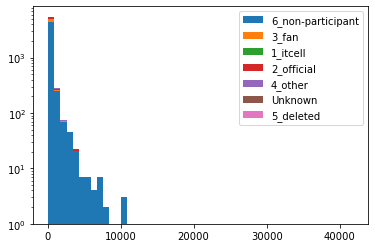

In [94]:
stacked_hist(res, bins=50, log=True, density=False)

In [59]:
print('number of users deemed participants:')
print(len(users.query('type != "6_non-participant"')))
print('total users:')
print(len(users))

number of users deemed participants:
4750
total users:
244113


In [69]:
user_breakdown = users.groupby('type').count().templates.transform(lambda x: x/x.sum())
user_breakdown_participants = users.query('type != "6_non-participant"').groupby('type').count()\
.templates.transform(lambda x: x/x.sum())

([<matplotlib.patches.Wedge at 0x2aac7cf85820>,
 [Text(1.0999639604367664, 0.008904254054343915, '1_itcell'),
  Text(1.099773180874022, 0.02233720282926556, '2_official'),
  Text(1.099129232352179, 0.04375991989149227, '3_fan'),
  Text(1.0958853215648425, 0.09505452108512269, '4_other'),
  Text(1.0920800568963238, 0.13176171420151733, '5_deleted'),
  Text(-1.0979453692338368, -0.06720093881765553, '6_non-participant')])

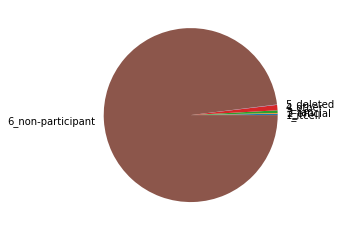

In [65]:
plt.pie(user_breakdown, labels=user_breakdown.index)

Text(0.5, 1.0, 'Breakdown of template users by type')

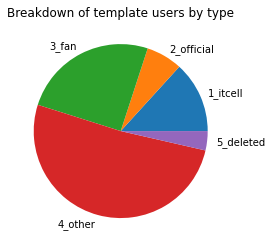

In [73]:
plt.pie(user_breakdown_participants, labels=user_breakdown_participants.index)
plt.title('Breakdown of template users by type')

# Repeat Analysis but Without Bandwagon Hashtags

In [6]:
pure_campaigns = {k:v for k,v in campaigns.items() if k not in preprocessing.bandwagon_hashtags}

In [7]:
is_template = lambda x: not x.root.template == ''
template_cascades = preprocessing.process_campaign(pure_campaigns,
                                                   filter_func=is_template)

100%|██████████| 68/68 [00:10<00:00,  6.29it/s]


In [8]:
is_not_template = lambda x: x.root.template == ''
not_template_cascades = preprocessing.process_campaign(pure_campaigns,
                                                       filter_func=is_not_template)

100%|██████████| 68/68 [00:10<00:00,  6.51it/s]


Text(0, 0.5, '# of cascades')

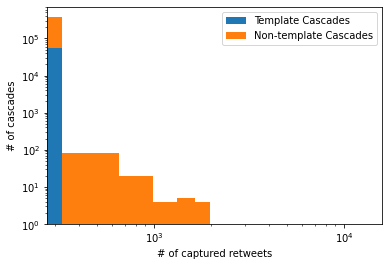

In [9]:
temp = [x.n_retweets for x in template_cascades]
no_temp = [x.n_retweets for x in not_template_cascades]

plt.hist([temp, no_temp], bins=40, stacked=True, density=False, log=False, label=['Template Cascades', 
                                                                                 'Non-template Cascades'])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('# of captured retweets')
plt.ylabel('# of cascades')

In [12]:
min_size = lambda x: x.n_retweets > 50
res = preprocessing.process_campaign(pure_campaigns, filter_func=min_size)
top_tweets = [t for c in res for t in c.get_top_tweets(thresh=5)]

100%|██████████| 68/68 [00:08<00:00,  7.87it/s]


In [13]:
def summarize_top_tweets(top_tweets, rt_thresh=0):
    # input: [(Tweet, (implied) RT count)]
    # output: info about these tweets
    labels = []#[get_user_type(tweet.username) for tweet, rt_count in top_tweets]
    rt_counts = []#[rt_count for tweet, rt_count in top_tweets]
    
    label_dict = {}
    for tweet, rt_count in top_tweets:
        if rt_count > rt_thresh:
            user_type = users.type.get(tweet.username, 'Unknown')
            labels.append(user_type)
            rt_counts.append(rt_count)
            temp = label_dict.get(user_type, [])
            temp.append(rt_count)
            label_dict[user_type] = temp
    
    return label_dict

Text(0.5, 1.0, 'Distribution of Tweets with 50+ RTs by User Type')

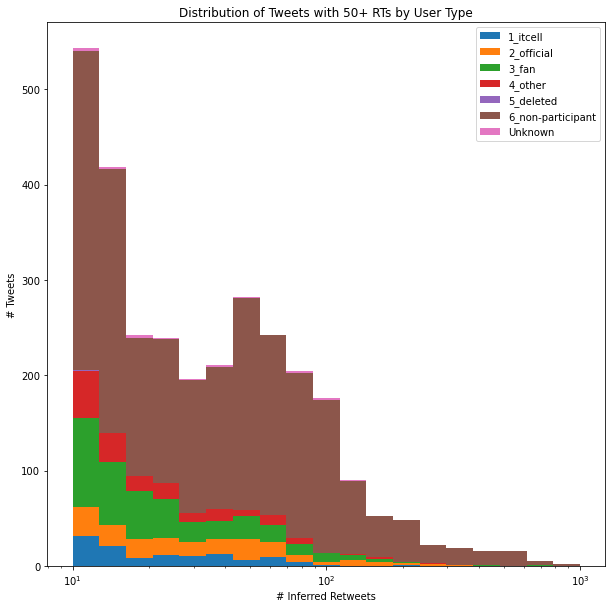

In [15]:
label_dict = summarize_top_tweets(top_tweets)
keys, values = list(label_dict.keys()), list(label_dict.values())
sorted_keys, sorted_values = zip(*sorted(zip(keys, values), key=lambda x: x[0]))

plt.figure(figsize=(10,10))
logbins = np.geomspace(10, 1000, 20)
plt.hist(sorted_values, stacked=True, label=sorted_keys, bins=logbins)
plt.legend()
plt.xscale('log')
plt.xlabel('# Inferred Retweets')
plt.ylabel('# Tweets')
plt.title('Distribution of Tweets with 50+ RTs by User Type')
#plt.savefig('top_tweets_by_user.png')

In [18]:
def extract_tweets(cascade, result_list, min_size=50, rt_thresh=5, template=False):
    ''' Helper function takes a cascade and builds 
    a global list top_tweets with tweets that satisfy the various criteria
    min_size: the # of tweets in a cascade to be considered
    rt_thresh: how many rts a tweet has to have to be added
    template: boolean for whether the root must be a template
    '''
    if template and cascade.root.template == '':
        return
    if cascade.n_retweets > min_size:
        result_list += cascade.get_top_tweets(thresh=rt_thresh)
        
template_rts = []
for tag, tweets in pure_campaigns.items():
        preprocessing.parse_cascades_low_mem(*preprocessing.process_tweet_ts(tweets.values()), 
                               cascade_func=lambda x: extract_tweets(x, template_rts, min_size=0, 
                                                                     rt_thresh=0, template=True))

 10%|▉         | 713/7386 [00:00<00:00, 7070.45it/s]

'missing_1082197976494292992'
'missing_1081808701944516608'
'missing_1081813653798539264'
'missing_1097054185340600320'
'missing_1097054219763240961'
'missing_1097054259810463744'
'missing_1097054302961463296'
'missing_1097054343587491841'
'missing_1097056302415499264'
'missing_1097061396322242560'
'missing_1097061892059652096'
'missing_1097061900758638592'
'missing_1097061940298305536'
'missing_1097061955276173313'
'missing_1097061966336512000'
'missing_1097061979800260608'
'missing_1097061990403457024'
'missing_1097061998813011969'
'missing_1097062008078315520'
'missing_1097062016596889600'
'missing_1097062032392609793'
'missing_1097062048075141120'
'missing_1097062058607075328'
'missing_1097062068442656769'
'missing_1097062075824631808'
'missing_1097062085811306497'
'missing_1097062104786362368'
'missing_1097062229193703424'
'missing_1097093032145412096'
'missing_1097062311943200768'
'missing_1097062705264033793'
'missing_1097105289440948225'
'missing_1097063853869871104'


100%|██████████| 532/532 [00:00<00:00, 11216.92it/s]


'missing_1097074716408467456'
'missing_1097099582788358148'
'missing_1097089361365983234'
'missing_1097135731816964096'
'missing_1097744831579750400'
'missing_1097079997695574017'
'missing_1097080063466459136'
'missing_1097080098405011458'
'missing_1097080199022141441'
'missing_1097097488991956994'
'missing_1097080335135735808'
'missing_1097080942332727297'
'missing_1097082817052377089'
'missing_1097083608945311746'
'missing_1097083613944991744'
'missing_1097083612258803712'
'missing_1097083610581135360'
'missing_1097085177199771649'
'missing_1097086526142513153'
'missing_1097119501185896448'
'missing_1097086711450857472'
'missing_1097086739804352512'
'missing_1097092744860692480'
'missing_1097093247623520257'
'missing_1097105153407086593'
'missing_1097092830671994881'
'missing_1097092841187069952'
'missing_1097105161053396994'
'missing_1097092876608012288'
'missing_1097105212446130176'
'missing_1097093361243025408'
'missing_1097093412623269888'
'missing_1097092921256366080'
'missing_1

  5%|▍         | 732/15648 [00:00<00:02, 7308.61it/s]

'missing_1061445754080772096'
'missing_1061447830479560706'
'missing_1061590973984071686'
'missing_1061489470929821696'
'missing_1061497901795307522'
'missing_1061488952127873024'
'missing_1061497536874188800'
'missing_1061489949218889728'
'missing_1061490078009176064'
'missing_1061492580435804160'
'missing_1061491199394111489'
'missing_1061524405052788737'
'missing_1061492730570911745'
'missing_1061494212602953728'
'missing_1061491957682323463'
'missing_1061501054876033024'
'missing_1061492468628242432'
'missing_1063032260977258496'
'missing_1061860992940826624'
'missing_1061534399907422208'
'missing_1061560485433106432'
'missing_1061492677995360256'
'missing_1061492718625583104'
'missing_1061492726821281792'
'missing_1061492773285707776'
'missing_1061540014063079424'
'missing_1061492797491023872'
'missing_1061501051247837184'
'missing_1061492842558828544'
'missing_1061492873764524032'
'missing_1061494083594539008'
'missing_1061493092988215298'
'missing_1061493123086467072'
'missing_1

 85%|████████▌ | 13314/15648 [00:00<00:00, 14767.40it/s]

'missing_1061511851928768512'
'missing_1061511962918445056'
'missing_1061514619137605633'
'missing_1061512139918184448'
'missing_1061513369667203072'
'missing_1061517326829453312'
'missing_1061518023398428672'
'missing_1061512328879853568'
'missing_1061512976698621952'
'missing_1061512474342711296'
'missing_1061512482857062400'
'missing_1061519620581048320'
'missing_1061512515178455040'
'missing_1061512914824237056'
'missing_1061515060068188160'
'missing_1061512544588832768'
'missing_1061515044129828864'
'missing_1061514203306057728'
'missing_1061512878140862465'
'missing_1061524734402289664'
'missing_1061512898634227713'
'missing_1061512946327666689'
'missing_1061513384829562880'
'missing_1061513457592426496'
'missing_1061513603176632321'
'missing_1061601016120979457'
'missing_1061513624341098496'
'missing_1061520333537046528'
'missing_1061522398606815232'
'missing_1061514202504982529'
'missing_1061514242753486848'
'missing_1061514279235534848'
'missing_1061514582919864321'
'missing_1

 39%|███▊      | 1150/2973 [00:00<00:00, 11499.82it/s]

'missing_1089950873109712896'
'missing_1090044068019748869'
'missing_1090092488436535296'
'missing_1090044151268282371'
'missing_1090122368461070337'
'missing_1090044266804637697'
'missing_1090054147913719816'
'missing_1090054758260445184'
'missing_1090054770050691073'
'missing_1090054780922351616'
'missing_1090083659657310208'
'missing_1090054804783677447'
'missing_1090054813616914432'
'missing_1090054829513342976'
'missing_1090054843811749890'
'missing_1090054855287324673'
'missing_1090054864904876033'
'missing_1090054875759759361'
'missing_1090054888812408833'
'missing_1090084046703480832'
'missing_1090054912199852037'
'missing_1090054922903715842'
'missing_1090054933188104193'
'missing_1090054943652892673'
'missing_1090054960337874945'
'missing_1090054973797425157'
'missing_1090054983507152896'
'missing_1090054993053388800'
'missing_1090055003128111104'
'missing_1090055015178342400'
'missing_1090055025164988416'
'missing_1090055038741954560'
'missing_1090055049982763009'
'missing_1

  0%|          | 0/2238 [00:00<?, ?it/s]

'missing_1090135503960268805'
'missing_1090137650764238848'
'missing_1090140318459019265'
'missing_1090142445504028673'
'missing_1090142837209915392'
'missing_1090142866842705920'
'missing_1090144915370078210'
'missing_1090150990047838208'
'missing_1090150995500265472'
'missing_1090152818185523200'
'missing_1090222101921816576'
'missing_1090156978557444101'
'missing_1090166859486322688'
'missing_1090166868839587840'
'missing_1090166913131401216'
'missing_1090167114458005504'
'missing_1090168117022474241'
'missing_1090168133145350144'
'missing_1090247138150240257'
'missing_1090168152112082944'
'missing_1090246762546192384'
'missing_1090168344924237824'
'missing_1090171562332844033'
'missing_1090175980109324288'
'missing_1090176172854435840'
'missing_1090177171019030528'
'missing_1090177190925283328'
'missing_1090177301382193154'
'missing_1090177416952041474'
'missing_1090240594075475968'
'missing_1090182153302732802'
'missing_1090182658322120704'
'missing_1090230195762548736'
'missing_1

100%|██████████| 783/783 [00:00<00:00, 15034.10it/s]

'missing_1065872615452172288'
'missing_1065873844353843200'
'missing_1065874378032766976'
'missing_1065901021585494016'
'missing_1065943093768142848'
'missing_1065876101254258688'
'missing_1065878041665171456'
'missing_1065947759071522816'
'missing_1065943093046796290'
'missing_1065884721446453249'
'missing_1065889614752374784'
'missing_1066174297050275840'
'missing_1065895041644654592'
'missing_1066223671381872647'
'missing_1065907940492754944'
'missing_1065896413161242624'
'missing_1065896686961209344'
'missing_1065899126850760704'
'missing_1065901011062018050'
'missing_1065909169780330496'
'missing_1065901051264389120'
'missing_1066025212221648896'
'missing_1065904403176030208'
'missing_1065905061488979968'
'missing_1065905142124306432'
'missing_1065906822131982342'
'missing_1065909370024747009'
'missing_1065984208118509568'
'missing_1065914758753214464'
'missing_1065915383977140225'
'missing_1065918281150799872'
'missing_1065918673741766656'
'missing_1065918686345580544'
'missing_1


 15%|█▍        | 1540/10328 [00:00<00:01, 7491.28it/s]

'missing_1070211074459193344'
'missing_1070183527818428417'
'missing_1070183555442053120'
'missing_1070232546762354688'
'missing_1070282320861573122'
'missing_1070246530731233280'
'missing_1070259647070785536'
'missing_1070185391712436224'
'missing_1070234093512732672'
'missing_1070198399192846338'
'missing_1070232525967147008'
'missing_1070255775119958017'
'missing_1070187153571770369'
'missing_1070217650964455425'
'missing_1070187201072324609'
'missing_1070319203033395200'
'missing_1070719006250807296'
'missing_1070188508264820736'
'missing_1070243937737162752'
'missing_1070215806921924608'
'missing_1070200053611053056'
'missing_1070189480815005696'
'missing_1070191554600599552'
'missing_1070199237714038784'
'missing_1070238737139929089'
'missing_1070189983963717632'
'missing_1070190067782770688'
'missing_1070190286200954880'
'missing_1070215618761277440'
'missing_1070190454845644800'
'missing_1070190552354705408'
'missing_1070250813858168833'
'missing_1070206295884619776'
'missing_1

 25%|██▌       | 2593/10328 [00:00<00:01, 5577.52it/s]

'missing_1070197798321180674'
'missing_1070212565987459072'
'missing_1070396947314475011'
'missing_1070238067166982145'
'missing_1070232219992670209'
'missing_1070198814848376832'
'missing_1070199127202353152'
'missing_1070199223897845761'
'missing_1070199229098819586'
'missing_1070199279812145152'
'missing_1070199361575907329'
'missing_1070536622398029824'
'missing_1070199594779176960'
'missing_1070248376053194752'
'missing_1070202419831803904'
'missing_1070200003707191297'
'missing_1070275016493740032'
'missing_1070200357102477312'
'missing_1070200729049161728'
'missing_1070201146059444224'
'missing_1070229533427675137'
'missing_1070201412552781824'
'missing_1070204351849947137'
'missing_1070204945775951872'
'missing_1070201900732112896'
'missing_1070201973897478144'
'missing_1070202012464074752'
'missing_1070202264122507264'
'missing_1070202269893722112'
'missing_1070202445068943360'
'missing_1070202555156914176'
'missing_1070202565399318528'
'missing_1070245809415847936'
'missing_1

 42%|████▏     | 4359/10328 [00:00<00:00, 6843.18it/s]

'missing_1070203688835264512'
'missing_1070240494406512640'
'missing_1070203853520453632'
'missing_1070203900584701952'
'missing_1070203921996627970'
'missing_1070203956700344321'
'missing_1070204012631285760'
'missing_1070230162191507456'
'missing_1070204962544726017'
'missing_1070204189681213441'
'missing_1070204249261232128'
'missing_1070204336930725889'
'missing_1070204447454834688'
'missing_1070204517763964928'
'missing_1070547457807998976'
'missing_1070204567260925952'
'missing_1070204573866971136'
'missing_1070221099202338816'
'missing_1070541023204405248'
'missing_1070334748831055872'
'missing_1070334754405285889'
'missing_1070206251928182784'
'missing_1070218857283874816'
'missing_1070205576150310912'
'missing_1070218147507068928'
'missing_1070232115659370496'
'missing_1070206322912714752'
'missing_1070206378898350080'
'missing_1070234755906580480'
'missing_1070206467762937856'
'missing_1070280378844360705'
'missing_1070223848715382784'
'missing_1070207064167788544'
'missing_1

100%|██████████| 10328/10328 [00:00<00:00, 13753.87it/s]


'missing_1070222349977444352'
'missing_1070222365903200256'
'missing_1070222351751671808'
'missing_1070229235908952064'
'missing_1070222951151296512'
'missing_1070223131187576832'
'missing_1070234507045949440'
'missing_1070242141996224512'
'missing_1070223362289557506'
'missing_1070257528154542080'
'missing_1070223629768638469'
'missing_1070235613679575041'
'missing_1070232276771004421'
'missing_1070224380716818432'
'missing_1070224515513442304'
'missing_1070224529291702272'
'missing_1070224578717327361'
'missing_1070235586471051264'
'missing_1070224681565749248'
'missing_1070224713685893120'
'missing_1070225091143831553'
'missing_1070262605934194688'
'missing_1070226160502493184'
'missing_1070226306355335169'
'missing_1070226351263629312'
'missing_1070624351215595520'
'missing_1070237908706181120'
'missing_1070235989749174272'
'missing_1070320556510085120'
'missing_1070228180248772608'
'missing_1070230197226610690'
'missing_1070230285822976000'
'missing_1070230420242001920'
'missing_1

  0%|          | 0/720 [00:00<?, ?it/s]

'missing_1044183946936889344'
'missing_1044752789006635011'
'missing_1044289851238092800'
'missing_1044532458165800960'
'missing_1044594782717317123'
'missing_1044644753315323904'
'missing_1044600413591412738'
'missing_1044606135196684288'
'missing_1044644844889468928'
'missing_1044644884848640000'
'missing_1044644891471433728'
'missing_1044644957275938817'
'missing_1044645003241254912'
'missing_1044645085122506752'
'missing_1044660796112998400'
'missing_1044655026285813761'
'missing_1044719307286994945'
'missing_1044696179299225606'
'missing_1044819534115475456'
'missing_1044847752918814720'
'missing_1044875215480737793'
'missing_1044887155808636928'
'missing_1045335487068745729'
'missing_1045269570477588480'
'missing_1045239015492997121'
'missing_1045271289009766400'
'missing_1045549611757293570'
'missing_1045222076909408263'
'missing_1045234110103314432'
'missing_1045212467318738945'
'missing_1045517705023901698'
'missing_1045238165156454400'
'missing_1045260236016226305'
'missing_1

  0%|          | 0/1912 [00:00<?, ?it/s]

'missing_1098485225703694336'
'missing_1098479255112044544'
'missing_1098479275861266432'
'missing_1098479294576238593'
'missing_1098479315774263296'
'missing_1098480413880840192'
'missing_1098479532669956097'
'missing_1098501012535554050'
'missing_1098482313757773824'
'missing_1098500984106639360'
'missing_1098500975382462464'
'missing_1098500929840656385'
'missing_1098500685560205314'
'missing_1098500632066097152'
'missing_1098480792290832384'
'missing_1098481283196284928'
'missing_1098481305392635904'
'missing_1098481357897039877'
'missing_1098500227571613696'
'missing_1098500219153588224'
'missing_1098481437253296128'
'missing_1098481512587186176'
'missing_1098481536377257989'
'missing_1098483305522126849'
'missing_1098500157996523521'
'missing_1098500146579587073'
'missing_1098500135103942656'
'missing_1098500098693185536'
'missing_1098482090218156032'
'missing_1098499867754852352'
'missing_1098499840676372480'
'missing_1098482706827100160'
'missing_1098502602763976704'
'missing_1

  0%|          | 0/2790 [00:00<?, ?it/s]

'missing_1082161757295202304'
'missing_1082161845513961474'
'missing_1082162077479821313'
'missing_1082218560670367744'
'missing_1082163165968900096'
'missing_1082163518718173184'
'missing_1082163989251944448'
'missing_1082164213013860353'
'missing_1082165333610254337'
'missing_1082192748290031616'
'missing_1082166538969395200'
'missing_1082166577255014400'
'missing_1082166763154857984'
'missing_1082171580950601730'
'missing_1082172178399932416'
'missing_1082273345100365824'
'missing_1082171026375622656'
'missing_1082171239475621889'
'missing_1082308480009043968'
'missing_1082274632105775104'
'missing_1082172464304599040'
'missing_1082173523336953861'
'missing_1082194136797757440'
'missing_1082175624024711169'
'missing_1082175870167445504'
'missing_1082175937368580096'
'missing_1082175953164324865'
'missing_1082205909265244160'
'missing_1082176634365431808'
'missing_1082182268314050561'
'missing_1082177946616508416'
'missing_1082463904817504257'
'missing_1082178962774609921'
'missing_1

100%|██████████| 1626/1626 [00:00<00:00, 41108.73it/s]


'missing_1070177180892581888'
'missing_1070181596538462210'
'missing_1070167143633903616'
'missing_1070167164370464768'
'missing_1070167227574444034'
'missing_1070175231447195649'
'missing_1070168267245916161'
'missing_1070187934274310144'
'missing_1070170569730011137'
'missing_1070171619778330624'
'missing_1070171950318804994'
'missing_1070172082997288960'
'missing_1070172112747462656'
'missing_1070303230486171648'
'missing_1070173005521805312'
'missing_1070173208458870784'
'missing_1070173280399777792'
'missing_1070185011654156288'
'missing_1071050504829001728'
'missing_1070738244306796544'
'missing_1070175522926223360'
'missing_1070177145995948033'
'missing_1070181436387278848'
'missing_1070178167766171648'
'missing_1070177275679694849'
'missing_1070181482658856960'
'missing_1070177413127004161'
'missing_1070177884973592576'
'missing_1070177956289437697'
'missing_1070177992553332736'
'missing_1070178113223516162'
'missing_1070178125856702464'
'missing_1070178138527694848'
'missing_1

 30%|██▉       | 3643/12215 [00:00<00:00, 18549.14it/s]

'missing_1103837066389929985'
'missing_1103837375149588481'
'missing_1103837393289920514'
'missing_1103861170014842880'
'missing_1103850097291476992'
'missing_1103837931633020928'
'missing_1103838176567791619'
'missing_1103838481120280576'
'missing_1103850118854463488'
'missing_1103946086215872512'
'missing_1103838618609569792'
'missing_1103841494429913088'
'missing_1103838648196165632'
'missing_1103839096504385536'
'missing_1103905069970317314'
'missing_1103839093526474753'
'missing_1103842978307682306'
'missing_1103839099427803136'
'missing_1103848267912306688'
'missing_1103946176317943808'
'missing_1104057125225955328'
'missing_1103839273218961409'
'missing_1103839568644706305'
'missing_1103920868038664193'
'missing_1103839873168039936'
'missing_1103912543695695872'
'missing_1103901568900882434'
'missing_1103875151194599429'
'missing_1103974656573267968'
'missing_1103841485949100032'
'missing_1103840373120462848'
'missing_1103849618310352897'
'missing_1103840590909693952'
'missing_1

 57%|█████▋    | 6916/12215 [00:00<00:00, 16930.30it/s]

'missing_1103889666632118273'
'missing_1103896343729201153'
'missing_1103890813023531008'
'missing_1103890928761135104'
'missing_1103890997392502785'
'missing_1103891112354209797'
'missing_1103969054933598208'
'missing_1103892652972335104'
'missing_1103892794865704963'
'missing_1103893001871360000'
'missing_1103902163959336960'
'missing_1103904690520055808'
'missing_1106452215890206721'
'missing_1103950480626147329'
'missing_1103893125737545735'
'missing_1103893459268644865'
'missing_1103894389456166913'
'missing_1103893599354204160'
'missing_1103893686683762694'
'missing_1103893726294753280'
'missing_1103893746469335045'
'missing_1104265093712359424'
'missing_1103893882515861504'
'missing_1103910641964728321'
'missing_1104005775721082880'
'missing_1103894183473897475'
'missing_1103894324587094019'
'missing_1103894524269539328'
'missing_1103894670759714816'
'missing_1104705954682232832'
'missing_1103896883473207297'
'missing_1103895083579932678'
'missing_1103895158603448321'
'missing_1

100%|██████████| 12215/12215 [00:00<00:00, 20324.88it/s]


'missing_1103921473268244486'
'missing_1103921633331359745'
'missing_1103921822288891905'
'missing_1103921945282637825'
'missing_1103922362095824899'
'missing_1103922501715812359'
'missing_1103923150725607424'
'missing_1103923258166931458'
'missing_1103923708161224704'
'missing_1103935412655947776'
'missing_1103924218872229888'
'missing_1103925114091954179'
'missing_1103927920983105537'
'missing_1103925276189184000'
'missing_1103969777352093698'
'missing_1103925736279236609'
'missing_1103926307774029824'
'missing_1103926466775986176'
'missing_1103926469418336256'
'missing_1103926461784711168'
'missing_1103926441446522881'
'missing_1103926426418393090'
'missing_1103926446462922752'
'missing_1103926438917373954'
'missing_1103926464385146880'
'missing_1103926434043580416'
'missing_1103926452985053195'
'missing_1103926431396950016'
'missing_1103926459041640448'
'missing_1103935630331899904'
'missing_1103926617884123136'
'missing_1103927248019611648'
'missing_1103927551339069440'
'missing_1

 20%|██        | 845/4143 [00:00<00:00, 8387.22it/s]

'missing_1052752327063396352'
'missing_1052414524958142464'
'missing_1052414826486620160'
'missing_1052416400529207297'
'missing_1052420693969829888'
'missing_1052422166535389184'
'missing_1052423702468587520'
'missing_1052423825965633536'
'missing_1052424441018425344'
'missing_1052425005500440576'
'missing_1052425098014191616'
'missing_1052425446162399233'
'missing_1052425476294230016'
'missing_1052425528060379138'
'missing_1052425529805168641'
'missing_1052426077430325250'
'missing_1052426425066823681'
'missing_1052426437238693889'
'missing_1052426490514735105'
'missing_1052426502808240128'
'missing_1052426521816825856'
'missing_1052437485912055809'
'missing_1052427746486444037'
'missing_1052427970818793472'
'missing_1052429090790232064'
'missing_1052450161572675584'
'missing_1052432669655617541'
'missing_1052432100215926784'
'missing_1052432724479434752'
'missing_1052432155727540225'
'missing_1052437994345508866'
'missing_1052432282802417664'
'missing_1052432455616086018'
'missing_1

 43%|████▎     | 1783/4143 [00:00<00:00, 5992.21it/s]

'missing_1074212298267320320'
'missing_1074211817625251840'
'missing_1074213931701305344'
'missing_1077835650240376832'
'missing_1074213028030103552'
'missing_1074212042758713345'
'missing_1074212190830223360'
'missing_1074297283389222912'
'missing_1074216387667619841'
'missing_1074213914471149569'
'missing_1074214066837581824'
'missing_1074213351817768960'
'missing_1074213414728196096'
'missing_1074215390404722688'
'missing_1074213848113016833'
'missing_1074215415012675584'
'missing_1074213587286020099'
'missing_1074213755171422208'
'missing_1074214677192728578'
'missing_1074370089720266752'
'missing_1074214660616871936'
'missing_1074214986057039874'
'missing_1074214988443611137'
'missing_1074215175840878593'
'missing_1074215245474803713'
'missing_1074219208735485954'
'missing_1074220880820002816'
'missing_1074219452525236225'
'missing_1074215672119316480'
'missing_1074218317353611264'
'missing_1074216006115979264'
'missing_1074216276921180161'
'missing_1074216425403777024'
'missing_1

  0%|          | 0/7136 [00:00<?, ?it/s]

'missing_1074250105853599744'
'missing_1074250359520948224'
'missing_1074250397097709569'
'missing_1074251854828240896'
'missing_1074252222500810754'
'missing_1074253749227532293'
'missing_1074253161341149184'
'missing_1074295770365480961'
'missing_1074526549049634816'
'missing_1076382271236722688'
'missing_1074255781803900930'
'missing_1074482121471864833'
'missing_1074256322277720064'
'missing_1074469260905340928'
'missing_1074305696974270464'
'missing_1074257146659786754'
'missing_1074257303610613760'
'missing_1074331428584857607'
'missing_1074257487493160961'
'missing_1074262675918483456'
'missing_1074323535240224768'
'missing_1074258649969770496'
'missing_1074258790122307586'
'missing_1074262717991534593'
'missing_1074259423969722368'
'missing_1074264032092307457'
'missing_1074292760939778049'
'missing_1074631386034622464'
'missing_1074271361944686593'
'missing_1074260051869626374'
'missing_1074260113102376960'
'missing_1074264449320660992'
'missing_1074264239567765504'
'missing_1

100%|██████████| 641/641 [00:00<00:00, 26090.51it/s]


'missing_1060392802746425344'
'missing_1060682979180273664'
'missing_1060393560493584384'
'missing_1060393709932490752'
'missing_1060485254035628032'
'missing_1060396956952887296'
'missing_1060397595070066688'
'missing_1060394698743803905'
'missing_1060419641007194112'
'missing_1060517342021607424'
'missing_1060395120124616704'
'missing_1060395318846472192'
'missing_1060437264843636737'
'missing_1060397011487191040'
'missing_1060396201520975872'
'missing_1060708106462617600'
'missing_1060397164432515072'
'missing_1060397316258054144'
'missing_1060397312873320455'
'missing_1060397314441916416'
'missing_1060397318535569408'
'missing_1060405221900247040'
'missing_1060398735920939008'
'missing_1060401929187057664'
'missing_1060398876648062976'
'missing_1060399314546024450'
'missing_1060449187714613248'
'missing_1060424062772510720'
'missing_1060400680077164546'
'missing_1060407739346673664'
'missing_1060401318412484608'
'missing_1060511187664883712'
'missing_1060401778372435968'
'missing_1

  0%|          | 0/2337 [00:00<?, ?it/s]

'missing_1118428049488265217'
'missing_1118392249350488064'
'missing_1118396732042170369'
'missing_1118393657319657473'
'missing_1118452080845266946'
'missing_1118480124679077888'
'missing_1118393875171807232'
'missing_1118393898810974209'
'missing_1118475906983424000'
'missing_1118481339299188737'
'missing_1118393991521816576'
'missing_1118547047534096384'
'missing_1118394326294368256'
'missing_1118481904896892929'
'missing_1118395727061741568'
'missing_1118396205413703680'
'missing_1118396813042520064'
'missing_1118396885407080448'
'missing_1118430316996071425'
'missing_1118397300341129216'
'missing_1118397005984722944'
'missing_1118397276206972928'
'missing_1118402379752198150'
'missing_1118397499654328320'
'missing_1118397568520609792'
'missing_1118397621356204032'
'missing_1118397826961010691'
'missing_1118398177101500416'
'missing_1118398413740003335'
'missing_1118409069033709568'
'missing_1118406643329294336'
'missing_1118405649338183680'
'missing_1118474844855648256'
'missing_1

  0%|          | 0/1431 [00:00<?, ?it/s]

'missing_1105851421772017665'
'missing_1105853141432430592'
'missing_1105853907807416320'
'missing_1105853575316541442'
'missing_1105894022441136128'
'missing_1105853703125385216'
'missing_1105862202806886400'
'missing_1105854945192861696'
'missing_1106895365133881344'
'missing_1105897714686951424'
'missing_1106064431685996545'
'missing_1106813375927844864'
'missing_1105855563487997952'
'missing_1106088449461768192'
'missing_1105856815927943169'
'missing_1105857865770627073'
'missing_1105856749163159553'
'missing_1105856769346154497'
'missing_1105866755740745728'
'missing_1105857545359540225'
'missing_1105857557967466496'
'missing_1106017933308747776'
'missing_1105858101838835712'
'missing_1105858196160299009'
'missing_1105858781617905664'
'missing_1105859676023939072'
'missing_1105860672410271745'
'missing_1105859948389588992'
'missing_1105860154719916033'
'missing_1105860425478856711'
'missing_1105860817445158912'
'missing_1105861072467173376'
'missing_1106127205648617473'
'missing_1

 12%|█▏        | 146/1209 [00:00<00:00, 1453.64it/s]

'missing_1040536291815960577'
'missing_1040817391226183680'
'missing_1040536927890399235'
'missing_1040536775704240129'
'missing_1040536817986985984'
'missing_1040537077337804800'
'missing_1040538648465166336'
'missing_1040538865155493888'
'missing_1040539924703764482'
'missing_1040556259215208448'
'missing_1040599928316289025'
'missing_1040555317170503681'
'missing_1040577751810433025'
'missing_1040563180928303105'
'missing_1040541325861433344'
'missing_1040606466837643264'
'missing_1040541527825539072'
'missing_1040554457321226241'
'missing_1040545500972371968'
'missing_1041234471154937857'
'missing_1040546593991061504'
'missing_1040556903317811200'
'missing_1040613174200811526'
'missing_1040550642664833024'
'missing_1040586555004350464'
'missing_1040579760710025216'
'missing_1040564030325157889'
'missing_1040560754615902209'
'missing_1040562946353487872'
'missing_1040563798254411776'
'missing_1040565264771821569'
'missing_1041173721833123842'
'missing_1041031100787712000'
'missing_1

100%|██████████| 386/386 [00:00<00:00, 16611.10it/s]


'missing_1099143930312982528'
'missing_1099178062514507779'
'missing_1099218388948144130'
'missing_1098847665591410688'
'missing_1099511898834227200'
'missing_1098958815397961728'
'missing_1098852789588033536'
'missing_1099517906428211200'
'missing_1098994444475330561'
'missing_1098856671198175232'
'missing_1098923367116111873'
'missing_1098856698255560704'
'missing_1098857057158017025'
'missing_1099478543497478145'
'missing_1098861171573178369'
'missing_1098924640230039553'
'missing_1098924624161628165'
'missing_1098862800368070657'
'missing_1098879096061218816'
'missing_1098863240283635712'
'missing_1098872211748732928'
'missing_1098873550059028482'
'missing_1098906546111541248'
'missing_1098867129271681024'
'missing_1098984027162271744'
'missing_1098891739694157824'
'missing_1098869661473488896'
'missing_1099353590290739200'
'missing_1098893637696528385'
'missing_1098893574874284032'
'missing_1098905181020815360'
'missing_1099337427972440064'
'missing_1099218332157337601'
'missing_1

 21%|██▏       | 5826/27244 [00:00<00:00, 58258.39it/s]

'missing_604029681671610368'
'missing_607980015649579008'
'missing_608683157257256961'
'missing_611091503616626688'
'missing_625637016252760064'
'missing_625650412582932480'
'missing_628235990654582784'
'missing_632298448293785600'
'missing_632431216134766592'
'missing_632407352633724929'
'missing_632437082628096000'
'missing_632437285787561984'
'missing_636366153594474496'
'missing_647269818823929857'
'missing_697443803293229056'
'missing_699680764359680001'
'missing_753601278060572672'
'missing_699893223188099073'
'missing_700993602164383744'
'missing_702323568210608128'
'missing_702531376835383296'
'missing_702895222250835968'
'missing_711063104856203264'
'missing_703581176703811584'
'missing_705653287656140800'
'missing_709377432369930240'
'missing_709426863760744448'
'missing_709407886410010625'
'missing_709417051996065794'
'missing_709423581977907200'
'missing_709431402584879110'
'missing_709442184475504640'
'missing_709445245109276672'
'missing_709585295671480320'
'missing_70946

  0%|          | 0/2606 [00:00<?, ?it/s]

'missing_1073862251256442880'
'missing_1073907121769435137'
'missing_1073936646809083906'
'missing_1074285790497189888'
'missing_1074188342986588160'
'missing_1094990109580148736'
'missing_1074198213761097728'
'missing_1074210018403209216'
'missing_1074263375390142464'
'missing_1074378411429298177'
'missing_1074531744127172609'
'missing_1074532577703190529'
'missing_1074533107464892416'
'missing_1074537061028249601'
'missing_1074545026393231361'
'missing_1074590987760984066'
'missing_1074939620662468610'
'missing_1074953462075387904'
'missing_1075030149421195264'
'missing_1075179468430434304'
'missing_1075094911878258688'
'missing_1075227271932170240'
'missing_1075267029626544128'
'missing_1075286645857935360'
'missing_1075326342969942017'
'missing_1076434949006217218'
'missing_1075356736213549056'
'missing_1075368863590563840'
'missing_1075378670724800514'
'missing_1075986253462585344'
'missing_1075900734191865857'
'missing_1076065269301166081'
'missing_1076086642249674752'
'missing_1

 68%|██████▊   | 1769/2606 [00:00<00:00, 7415.00it/s] 

'missing_1082272564754341890'
'missing_1082272615874478082'
'missing_1082272634140676096'
'missing_1082272660476768257'
'missing_1082273817869893634'
'missing_1082286378224766976'
'missing_1082279278421643265'
'missing_1082299266880565248'
'missing_1082283462470512640'
'missing_1082276053479960578'
'missing_1082276134115393536'
'missing_1082279314182361089'
'missing_1082276203090853889'
'missing_1082276310708154368'
'missing_1082276331545608193'
'missing_1082281695729004544'
'missing_1082276440182349825'
'missing_1082285914099933184'
'missing_1082313213646000129'
'missing_1082291542776111106'
'missing_1082301194570129408'
'missing_1082278213403926529'
'missing_1082284071290458112'
'missing_1090613219360718848'
'missing_1082279366300704769'
'missing_1082308776449912832'
'missing_1082284130627346432'
'missing_1082285858424668161'
'missing_1082285764480626688'
'missing_1082284116102410241'
'missing_1082282187586600961'
'missing_1090616144489140225'
'missing_1082280641977212929'
'missing_1

100%|██████████| 2606/2606 [00:00<00:00, 7493.41it/s]


'missing_1090621824688218113'
'missing_1090628063304400896'
'missing_1090609568256835584'
'missing_1090612473185464320'
'missing_1090611641694253056'
'missing_1090614251973005312'
'missing_1090610165743677441'
'missing_1090609995333410816'
'missing_1090618811881943041'
'missing_1090610363178016768'
'missing_1090618859302744070'
'missing_1090614745705590784'
'missing_1090610551820963840'
'missing_1090610632154435587'
'missing_1090610713645576195'
'missing_1090610749146312712'
'missing_1090611506046222336'
'missing_1090612897250603008'
'missing_1090610788547641344'
'missing_1090610893535117312'
'missing_1090611070295715840'
'missing_1090611121004789765'
'missing_1090611597570117632'
'missing_1090613649029267457'
'missing_1090626051410022400'
'missing_1090623970607419392'
'missing_1090611566158872578'
'missing_1090613898296717313'
'missing_1090835751997034496'
'missing_1090626840064974849'
'missing_1090614667938910208'
'missing_1090626081470775296'
'missing_1090912649032814592'
'missing_1

  2%|▏         | 513/28380 [00:00<00:05, 5129.74it/s]

'missing_1085043292645974016'
'missing_1085715950358282240'
'missing_1087566548989030401'
'missing_1085927643017592832'
'missing_1087633507101229056'
'missing_1086553844803428357'
'missing_1086903680543055873'
'missing_1086976869503623169'
'missing_1087011425720168453'
'missing_1087681054872203265'
'missing_1087565302760652800'
'missing_1087357355077992448'
'missing_1087566028886835201'
'missing_1087565741644308480'
'missing_1087551457027604486'
'missing_1087750813533884416'
'missing_1087552880041701377'
'missing_1087552887339864069'
'missing_1087552894201749505'
'missing_1087552991878615041'
'missing_1087552995263504384'
'missing_1087553004985823233'
'missing_1087553044420718592'
'missing_1087553059977351174'
'missing_1087553066721787904'
'missing_1087553093116538880'
'missing_1087553101765246976'
'missing_1087553319231541249'
'missing_1087553468305494016'
'missing_1087553552631902210'
'missing_1087553573364424709'
'missing_1087574689180835840'
'missing_1087553704906182656'
'missing_1

 33%|███▎      | 9330/28380 [00:00<00:01, 10773.18it/s]

'missing_1087561150806425600'
'missing_1087591561263644672'
'missing_1087561289977737216'
'missing_1087561303449849856'
'missing_1087562761117126656'
'missing_1087654005231284224'
'missing_1087561496874278913'
'missing_1087561711668756481'
'missing_1087634887778230272'
'missing_1087562179782561793'
'missing_1087572534604644352'
'missing_1087664315388162048'
'missing_1087579368585482240'
'missing_1087562595639320576'
'missing_1087562595047882752'
'missing_1087575329152032768'
'missing_1087562630624030721'
'missing_1087562639205588992'
'missing_1087562651763335169'
'missing_1087562678661304320'
'missing_1087562686420856833'
'missing_1087562690648653825'
'missing_1087562696424189960'
'missing_1087562705974611968'
'missing_1087562711657934849'
'missing_1087562725608194048'
'missing_1087562737071226881'
'missing_1087562743186518016'
'missing_1087562754204946432'
'missing_1087562776300515329'
'missing_1087562785318268928'
'missing_1087562790871519234'
'missing_1087562829492715520'
'missing_1

  0%|          | 0/412 [00:00<?, ?it/s]

'missing_1087652098374844418'
'missing_1087652130146508801'
'missing_1087652548545310720'
'missing_1087652598851620865'
'missing_1087652770872586240'
'missing_1087759360422363136'
'missing_1087672159550562305'
'missing_1087654409801089025'
'missing_1087654439417049089'
'missing_1087654520581050369'
'missing_1087654845622833152'
'missing_1087760431727497216'
'missing_1087715812876709894'
'missing_1087655077534359552'
'missing_1087655176448557056'
'missing_1087737435490938880'
'missing_1087656026873069568'
'missing_1087656634908901377'
'missing_1087656650612322305'
'missing_1087656876517425152'
'missing_1087657005815349248'
'missing_1087657021531406336'
'missing_1087657631882321921'
'missing_1087657643748061184'
'missing_1087696955906625536'
'missing_1087667608290131969'
'missing_1087744624322437120'
'missing_1087692889671458817'
'missing_1087731825420709890'
'missing_1087661172604784641'
'missing_1087661242896896001'
'missing_1087661401840054272'
'missing_1087661492575465473'
'missing_1

  6%|▋         | 299/4648 [00:00<00:01, 2976.48it/s]

'missing_1042783832527777793'
'missing_1042790778802765824'
'missing_1042793118050000898'
'missing_1042785201535901696'
'missing_1042785493296062464'
'missing_1042786099939074049'
'missing_1042786248580947968'
'missing_1042786455326580736'
'missing_1042786155555545090'
'missing_1042786996853256192'
'missing_1042787739471503360'
'missing_1042787817091301376'
'missing_1042790367505141760'
'missing_1042790775673708544'
'missing_1042791262955298817'
'missing_1042791386276352001'
'missing_1042791471684960256'
'missing_1042791525846077441'
'missing_1042792118874324993'
'missing_1042792225988640769'
'missing_1042792396357070848'
'missing_1042792742718513153'
'missing_1042792846443651073'
'missing_1042793492739571714'
'missing_1042807429715582978'
'missing_1042824736961650689'
'missing_1042831321125416960'
'missing_1042841368098271232'
'missing_1042841732306558976'
'missing_1042855395407093760'
'missing_1042859367861809152'
'missing_1042861052361232384'
'missing_1042861115019952128'
'missing_1

 53%|█████▎    | 2445/4648 [00:00<00:00, 4269.48it/s]

'missing_1074155513506496512'
'missing_1074156998529335296'
'missing_1074153953166790656'
'missing_1074153524563464192'
'missing_1074154103352242176'
'missing_1074212137038270464'
'missing_1074152879798345729'
'missing_1074153223366299648'
'missing_1074153233667497984'
'missing_1074371503943122944'
'missing_1074153432947159040'
'missing_1074176793496539136'
'missing_1074161697726889984'
'missing_1074159985167224832'
'missing_1074153720861085696'
'missing_1074195001071030272'
'missing_1074153816155668480'
'missing_1074209408295600128'
'missing_1074162488956964865'
'missing_1074154011400552448'
'missing_1074161715762343936'
'missing_1074154031092776960'
'missing_1074154040353800192'
'missing_1074154052429197312'
'missing_1074154061807738880'
'missing_1074154195027197952'
'missing_1074154285301202945'
'missing_1074154348664504320'
'missing_1074155217195753472'
'missing_1074155061717188610'
'missing_1074200620830121984'
'missing_1074155516375425025'
'missing_1074155625414828033'
'missing_1

 15%|█▍        | 315/2171 [00:00<00:00, 3133.42it/s]


'missing_1074456216934469632'
'missing_1074467853963800582'
'missing_1074495281398304768'
'missing_1074921761865641984'
'missing_1074470988157460480'
'missing_1075460870472232960'
'missing_1075460846824747008'
'missing_1074497536092708866'
'missing_1074503771709878275'
'missing_1074504910404648960'
'missing_1074505632068161536'
'missing_1074513505565302784'
'missing_1074513746003775490'
'missing_1074513618916392960'
'missing_1074513675979911168'
'missing_1074513719089029120'
'missing_1074513957421862912'
'missing_1074517821105811456'
'missing_1074519681074126848'
'missing_1074521770143727617'
'missing_1074523733325426688'
'missing_1074527790513426432'
'missing_1074534232632975360'
'missing_1074536746111578112'
'missing_1074541333467914241'
'missing_1074557429243830272'
'missing_1074557470092095488'
'missing_1074560885597892608'
'missing_1074564244748804097'
'missing_1074564734148431872'
'missing_1074566225408155648'
'missing_1074567960042192896'
'missing_1074596936223608833'
'missing_

  0%|          | 0/4655 [00:00<?, ?it/s]

'missing_1099245458960965633'
'missing_1099247174255165440'
'missing_1099245640645836800'
'missing_1099246235993554944'
'missing_1099249988192759808'
'missing_1134631840617181184'
'missing_1101736684876488704'
'missing_1099253711837134848'
'missing_1099560818981593089'
'missing_1099545184314880000'
'missing_1099250228874506240'
'missing_1099250337611825152'
'missing_1099269436203241472'
'missing_1099256738534969344'
'missing_1099251989785919488'
'missing_1099263493805625344'
'missing_1099253945078173697'
'missing_1099253807291068416'
'missing_1099253821979512832'
'missing_1099253989822984197'
'missing_1099253854233755648'
'missing_1099254034706264064'
'missing_1099253913625214976'
'missing_1099258102405189632'
'missing_1099272966976618496'
'missing_1099256420396978177'
'missing_1099256447567720448'
'missing_1099293108536258560'
'missing_1099264234582466566'
'missing_1099260439916146688'
'missing_1099258460267409408'
'missing_1099263946630942721'
'missing_1100404473573257224'
'missing_1

 13%|█▎        | 584/4655 [00:00<00:01, 2980.95it/s]

'missing_1097728519658848258'
'missing_1097710341549486080'
'missing_1097711400560996352'
'missing_1097710820723548163'
'missing_1097711633265246214'
'missing_1097728567000088576'
'missing_1097717257302466561'
'missing_1097743607639896065'
'missing_1097713111014944768'
'missing_1097713161606582272'
'missing_1097713271568621568'
'missing_1097743408511168512'
'missing_1097714575535788034'
'missing_1097714594242486272'
'missing_1097715134099742721'
'missing_1097895434683482112'
'missing_1097746927867912192'
'missing_1097882542705786881'
'missing_1097729238730305538'
'missing_1097716732309983233'
'missing_1097721985197498368'
'missing_1097792796050817024'
'missing_1098398294579937282'
'missing_1097717354132324354'
'missing_1097717666020814848'
'missing_1097724134505627648'


  0%|          | 0/1080 [00:00<?, ?it/s]

'missing_1097718876270411777'
'missing_1097718579892547586'
'missing_1097747225080283136'
'missing_1097719172543307776'
'missing_1097719659976163328'
'missing_1097747126736478209'
'missing_1097720215205343232'
'missing_1097782221040013313'
'missing_1097734526695063552'
'missing_1097721379040911361'
'missing_1097744060545024000'
'missing_1097799700290232320'
'missing_1097773500314529792'
'missing_1097745041328488448'
'missing_1097745073410732037'
'missing_1097728467330711552'
'missing_1097728552001101824'
'missing_1097742679822090240'
'missing_1097722740369313792'
'missing_1097723582581432320'
'missing_1097723611056529408'
'missing_1097723877654843392'
'missing_1097723903516897281'
'missing_1098088048871571457'
'missing_1097724886208794625'
'missing_1097725227109240839'
'missing_1097725706203582465'
'missing_1097751762151358464'
'missing_1097726120483446784'
'missing_1097726133632552961'
'missing_1097735979912200192'
'missing_1097726507412123649'
'missing_1097726402076434432'
'missing_1

  0%|          | 0/2013 [00:00<?, ?it/s]

'missing_1062579041495142400'
'missing_1062579078883143680'
'missing_1062579075758329857'
'missing_1062579093869391872'
'missing_1062579145744486400'
'missing_1062579176778199040'
'missing_1062579208092901377'
'missing_1062579219673309184'
'missing_1062579267714846720'
'missing_1062579308215091200'
'missing_1062579316104593409'
'missing_1062579325755637760'
'missing_1062579339378737152'
'missing_1062579346752397312'
'missing_1062579348673363968'
'missing_1062579385444847616'
'missing_1062579399944536064'
'missing_1062579417644457984'
'missing_1062579435747074048'
'missing_1062579445096243200'
'missing_1062579456752189440'
'missing_1062579473256726528'
'missing_1062580091237085189'
'missing_1062580337803431936'
'missing_1062580585984475136'
'missing_1062731648679129088'
'missing_1062581032136802304'
'missing_1062612348123308039'
'missing_1062581122477961216'
'missing_1062596312091131905'
'missing_1062589469377867777'
'missing_1062599235667935237'
'missing_1062584666132082688'
'missing_1

100%|██████████| 1637/1637 [00:00<00:00, 44366.82it/s]


'missing_1051721192711774209'
'missing_1051415196244180992'
'missing_1051414906493272064'
'missing_1051415000521170944'
'missing_1051415008595271680'
'missing_1051415012655259648'
'missing_1051415306122350592'
'missing_1051415025984782336'
'missing_1051415039205228544'
'missing_1051415041692426240'
'missing_1051416319474597889'
'missing_1051629243476664320'
'missing_1051416106685030401'
'missing_1051433553773436928'
'missing_1051416571665559552'
'missing_1051416594935468032'
'missing_1051428711856128000'
'missing_1051495776961085440'
'missing_1051416901438529536'
'missing_1051427621999976448'
'missing_1051418126238326784'
'missing_1051418379901329409'
'missing_1051421831801040896'
'missing_1051441694049296385'
'missing_1051419643267538946'
'missing_1051421103669702657'
'missing_1051424723337244673'
'missing_1051421728616923136'
'missing_1051421814293975041'
'missing_1051421868144508929'
'missing_1051526202492518400'
'missing_1051422550801051648'
'missing_1051422721899421696'
'missing_1

 23%|██▎       | 1707/7375 [00:00<00:00, 8708.20it/s]

'missing_1091214384280621056'
'missing_1091216766888333317'
'missing_1091217806794797056'
'missing_1091222270310113281'
'missing_1091237527690723329'
'missing_1091223718288736256'
'missing_1091240605705883648'
'missing_1091917257616183296'
'missing_1091280939144044544'
'missing_1091294684465545216'
'missing_1091304878842892288'
'missing_1091315253692948480'
'missing_1091325393078906881'
'missing_1091537751336501248'
'missing_1091341248361914373'
'missing_1091347693547315200'
'missing_1091525238452441088'
'missing_1091570093299970050'
'missing_1091917402562977792'
'missing_1092456455226023936'
'missing_1092692721163255809'
'missing_1092807461688487937'
'missing_1092845046175490050'
'missing_1093025212617056257'
'missing_1093137324383318016'
'missing_1093311467758055424'
'missing_1093338233432203264'
'missing_1093400312143069184'
'missing_1093422804601634816'
'missing_1093507231134318592'
'missing_1093501457645604865'
'missing_1093719141670940673'
'missing_1094147238606004224'
'missing_1

 82%|████████▏ | 6037/7375 [00:00<00:00, 12263.21it/s]

'missing_1099565717693726720'
'missing_1099567594170974208'
'missing_1099565840821760005'
'missing_1099565869150044161'
'missing_1099569014706061312'
'missing_1099565965577048064'
'missing_1099566049798676480'
'missing_1099683723702927360'
'missing_1099566174688301056'
'missing_1099566292430839809'
'missing_1099566439332282368'
'missing_1099875592386818049'
'missing_1099566510207430656'
'missing_1099566520609329154'
'missing_1099658798782967809'
'missing_1099567148828057600'
'missing_1099567163663298560'
'missing_1099567183460392962'
'missing_1099567247670931456'
'missing_1099567284840878081'
'missing_1099568849249136640'
'missing_1099957966738882560'
'missing_1099568933819043840'
'missing_1099567760730771456'
'missing_1099567817144365056'
'missing_1099567842511540225'
'missing_1099609002063814656'
'missing_1099567981749653504'
'missing_1099568070555648000'
'missing_1099568106081378304'
'missing_1100222237586669573'
'missing_1099572552354201601'
'missing_1099942672234614784'
'missing_1

100%|██████████| 1343/1343 [00:00<00:00, 36469.38it/s]


'missing_1082481110934847488'
'missing_1082481132820709376'
'missing_1082481147525906435'
'missing_1082481181206216704'
'missing_1082481239133687809'
'missing_1082483692327571457'
'missing_1082481788914524161'
'missing_1082482588592222208'
'missing_1082483522248404992'
'missing_1082483543022825472'
'missing_1082482645605347328'
'missing_1082483568696188929'
'missing_1082483581945970689'
'missing_1082482686566920192'
'missing_1082483603735339008'
'missing_1082482716862341120'
'missing_1082483626363645952'
'missing_1082483638388682752'
'missing_1082483651357491200'
'missing_1082482770348204032'
'missing_1082482784688496643'
'missing_1082483688930045953'
'missing_1082482816569360384'
'missing_1082482826325291008'
'missing_1082482843828146176'
'missing_1082483742105427968'
'missing_1082483758412967941'
'missing_1082482886349967360'
'missing_1082482899549532160'
'missing_1082483811915452416'
'missing_1082483826289344512'
'missing_1082483845155323904'
'missing_1082482974006730754'
'missing_1

  4%|▍         | 1197/29627 [00:00<00:08, 3394.30it/s]

'missing_1108349022744559616'
'missing_1107846497067040768'
'missing_1107846505535283200'
'missing_1107902461765795840'
'missing_1107846533624532992'
'missing_1107846588959870976'
'missing_1107942225458061312'
'missing_1107848629065261057'
'missing_1107848811861299200'
'missing_1107871696147496960'
'missing_1107848965066616832'
'missing_1107848991033589761'
'missing_1107871455591596034'
'missing_1107852757350780932'
'missing_1107902321424371712'
'missing_1107849567590965249'
'missing_1107884688415309826'
'missing_1107879429122875392'
'missing_1107849897292685312'
'missing_1107873685426233344'
'missing_1107850296582197248'
'missing_1107958500209164288'
'missing_1107854785615560705'
'missing_1107851026109853696'
'missing_1107886987325792256'
'missing_1108049836274647040'
'missing_1107990658273419264'


  8%|▊         | 2296/29627 [00:00<00:06, 4213.12it/s]

'missing_1107851496744353793'
'missing_1107886163392491520'
'missing_1107861129739423744'
'missing_1107855059209969664'
'missing_1107852419973550080'
'missing_1107861520292016129'
'missing_1107852656255471616'
'missing_1107860406444253185'
'missing_1107857278319898624'
'missing_1107907938595684353'
'missing_1107852990189318146'
'missing_1107853007012528128'
'missing_1107950280564314112'
'missing_1107853596509376514'
'missing_1107853762301820933'
'missing_1107885917295927303'
'missing_1107853812994170881'
'missing_1107853847479738368'
'missing_1108026508424241152'
'missing_1107863331996467201'
'missing_1107854024441651202'
'missing_1107869029103009792'
'missing_1107854169602289664'
'missing_1107854603079438336'
'missing_1107854662236016640'
'missing_1107854696121880576'
'missing_1107925524326703104'
'missing_1107854896861110275'
'missing_1107863457498447873'
'missing_1107855073508360192'
'missing_1107855102079954944'
'missing_1107855306808328192'
'missing_1107855389918408711'
'missing_1

 14%|█▎        | 4028/29627 [00:00<00:04, 5689.68it/s]

'missing_1107857770680717312'
'missing_1107857882693799936'
'missing_1107857880034639872'
'missing_1107857888423215104'
'missing_1107857916319531008'
'missing_1107863459885129728'
'missing_1107857952394743808'
'missing_1107858070556868608'
'missing_1107859852326371328'
'missing_1107860571909558272'
'missing_1107858762864300033'
'missing_1107858836453580801'
'missing_1107862553999360001'
'missing_1107925210722766848'
'missing_1107859816184078336'
'missing_1107907379952123904'
'missing_1107900446864097281'
'missing_1107860352224497664'
'missing_1107860351293538305'
'missing_1107860379143729152'
'missing_1107860424802947072'
'missing_1107877844451909633'
'missing_1107860752285736960'
'missing_1107860767079088128'
'missing_1107907334053879808'
'missing_1107860870065852419'
'missing_1108005635788935168'
'missing_1107900378308210688'
'missing_1107861169262354434'
'missing_1107861343854428160'
'missing_1107861519000170496'
'missing_1107861962061307904'
'missing_1107900323618680832'
'missing_1

 21%|██        | 6179/29627 [00:00<00:03, 7473.96it/s]

'missing_1107900054407245824'
'missing_1107992302037786629'
'missing_1107905954782208000'
'missing_1107867555719331840'
'missing_1107907160397144064'
'missing_1107867588388896768'
'missing_1107907167489875968'
'missing_1107878262653345793'
'missing_1107867638087086082'
'missing_1107867656965640192'
'missing_1107900193217773568'
'missing_1107867694047485952'
'missing_1107867715484549121'
'missing_1107907267892920320'
'missing_1108049775146999809'
'missing_1107868210135621632'
'missing_1107868375106113540'
'missing_1107868870327656448'
'missing_1107928239568121856'
'missing_1107869238826541056'
'missing_1107869380954619904'
'missing_1107869409358409729'
'missing_1107969185735270400'
'missing_1107907193548857344'
'missing_1107869748325302273'
'missing_1107869813739708417'
'missing_1107869842302877696'
'missing_1107869856890675200'
'missing_1107974504087605249'
'missing_1107952170781966336'
'missing_1107870516679979008'
'missing_1107870683172749312'
'missing_1107870695059447808'
'missing_1

 28%|██▊       | 8192/29627 [00:01<00:02, 8618.22it/s]

'missing_1107888583225032704'
'missing_1107882724717543424'
'missing_1107937129563189248'
'missing_1107881317079777281'
'missing_1107906616412626944'
'missing_1107961831983890432'
'missing_1107881707296813057'
'missing_1107882172491272193'
'missing_1107882236517339137'
'missing_1107882406302744576'
'missing_1107882429170089984'
'missing_1107882452796596225'
'missing_1107974339083669505'
'missing_1107882493523324929'
'missing_1107974394800803841'
'missing_1107882540772155393'
'missing_1107974431060561920'
'missing_1107882559269040128'
'missing_1107882568412618752'
'missing_1107882577560403968'
'missing_1107882586578153472'
'missing_1107974515127013377'
'missing_1107882619373404160'
'missing_1107974540619993091'
'missing_1107882652554530817'
'missing_1107882662369255424'
'missing_1107974587390648321'
'missing_1107882693591597056'
'missing_1107974623763685383'
'missing_1107882712935731203'
'missing_1107974646903631873'
'missing_1107882733148094470'
'missing_1107974668554657793'
'missing_1

 31%|███       | 9133/29627 [00:01<00:02, 8281.28it/s]

'missing_1107906209913307136'
'missing_1107906814174085121'
'missing_1107907485136875520'
'missing_1107908204359385088'
'missing_1108024707260010497'
'missing_1107970307187507200'
'missing_1107959929984507907'
'missing_1107908883425550341'
'missing_1107909510973128705'
'missing_1107955295706202112'
'missing_1107910500552048640'
'missing_1107975704422043648'
'missing_1107911499249401858'
'missing_1107911652572192768'
'missing_1107913392839254016'
'missing_1107914985710276609'
'missing_1107916712760872962'
'missing_1107917028290162688'
'missing_1107917547762905091'
'missing_1107917674456252417'
'missing_1107918706221428736'
'missing_1107921223118262272'
'missing_1107921291846148096'
'missing_1107941944670314496'
'missing_1107922760490049536'
'missing_1107923228335333376'
'missing_1107961042452148225'
'missing_1107941622652637189'
'missing_1107923574436716545'
'missing_1107923610553835521'
'missing_1107923805337337856'
'missing_1107924052151164928'
'missing_1107924301875838976'
'missing_1

 37%|███▋      | 10854/29627 [00:01<00:02, 7506.53it/s]

'missing_1107928091995721728'
'missing_1107929752713785344'
'missing_1107930802375950336'
'missing_1107960423662256128'
'missing_1107932376443703296'
'missing_1107933287572398081'
'missing_1107935021367771136'
'missing_1107935349546713089'
'missing_1107959548789166081'
'missing_1107940633883242496'
'missing_1107946938014396418'
'missing_1107941776570998784'
'missing_1107946352640561152'
'missing_1107941994184101888'
'missing_1107942039256100865'
'missing_1107942334984060928'
'missing_1107942360820916224'
'missing_1107943699470680069'
'missing_1107943848825643008'
'missing_1107945503516438529'
'missing_1107946005234769920'
'missing_1107946381317017601'
'missing_1107948526707732480'
'missing_1107949734684168192'
'missing_1107950545153593344'
'missing_1107952645073854464'
'missing_1107953959174660097'
'missing_1107953983711264768'
'missing_1107956034721800192'
'missing_1107967504591151104'
'missing_1108034978288300032'
'missing_1107959279024115717'
'missing_1107960074197061634'
'missing_1

100%|██████████| 550/550 [00:00<00:00, 37279.09it/s]

'missing_1109047765139632129'
'missing_1109059640292069378'
'missing_1109065356776083456'
'missing_1109079351730077706'
'missing_1115095146255663104'
'missing_1109114855561162753'
'missing_1109115170716962816'
'missing_1109127217039269894'
'missing_1109143252681146368'
'missing_1109153626256109570'
'missing_1109151465266925568'
'missing_1109324154648461312'
'missing_1109355930934743040'
'missing_1109388013539332096'
'missing_1109420231838089217'
'missing_1109439289807523841'
'missing_1109507748968857600'
'missing_1109507612138045440'
'missing_1109624414516248577'
'missing_1109661790705610754'
'missing_1109701402731921408'
'missing_1109743421780942848'
'missing_1109838571664367616'
'missing_1110050155103805440'
'missing_1110105796489076736'
'missing_1111140998841860097'
'missing_1111157258707238912'
'missing_1111160087240998914'
'missing_1111243569497407488'
'missing_1111244113989390336'
'missing_1111499318471610368'
'missing_1111531422659952640'
'missing_1111695084389457921'
'missing_1


  0%|          | 0/2201 [00:00<?, ?it/s]

'missing_1115844680879673345'
'missing_1067633916180393984'
'missing_1067829306166927360'
'missing_1118416712821432320'
'missing_1079771847565197314'
'missing_1115548476580827137'
'missing_1079750177173487617'
'missing_1079810126813356036'
'missing_1079790567389712397'
'missing_1079802558074351616'
'missing_1079735430818324481'
'missing_1079735609999179777'
'missing_1079735585277849600'
'missing_1079735634955096065'
'missing_1079735824206520320'
'missing_1079736782567092227'
'missing_1079754281576734722'
'missing_1079736592644751361'
'missing_1079737505241489408'
'missing_1079737905277370368'
'missing_1079752168599666699'
'missing_1079793275014242306'
'missing_1079739886377127938'
'missing_1079752905660362752'
'missing_1084338932651909120'
'missing_1079741983776632832'
'missing_1079985704703328256'
'missing_1079743486000271360'
'missing_1079743686097940480'
'missing_1079744462526525443'
'missing_1079748747683188738'
'missing_1079745508879581191'
'missing_1079746247265828864'
'missing_1

 15%|█▌        | 336/2201 [00:00<00:00, 3336.57it/s]

'missing_1117414067428372481'
'missing_1117434085373247488'
'missing_1117420593769590791'
'missing_1117420364525600768'
'missing_1117420580029042688'


 72%|███████▏  | 1583/2201 [00:00<00:00, 3793.43it/s]

'missing_1117423132053331968'
'missing_1117424404357500928'
'missing_1117424091688890368'
'missing_1117424098055835648'
'missing_1117424121405513733'
'missing_1117424147074732032'
'missing_1117424158550310912'
'missing_1117424172425039880'
'missing_1117424273490993153'
'missing_1117705052129386496'
'missing_1117426475810955264'
'missing_1117467348544438273'
'missing_1117427072585039872'
'missing_1117426989852516354'
'missing_1117427119586459649'
'missing_1117427142671962112'
'missing_1117446857687310336'
'missing_1117427530846416896'
'missing_1117427613344129024'
'missing_1117428720355225602'
'missing_1117429159347855360'
'missing_1117458558247768065'


  0%|          | 0/10996 [00:00<?, ?it/s]

'missing_1117440620706926594'
'missing_1117439365678940161'
'missing_1117444046056640513'
'missing_1117624776317526017'
'missing_1117447616348901376'
'missing_1117458453226770432'
'missing_1117481605541421057'
'missing_1117478603510484992'
'missing_1117666087993135110'
'missing_1117707201186009088'
'missing_1117707205594292224'
'missing_1117707203870363649'
'missing_1117707202528206848'
'missing_1117727134057811968'
'missing_1117755679308046336'
'missing_1117746988936654853'
'missing_1117807857464791040'
'missing_1117807863991169024'
'missing_1117807896924868610'
'missing_1117807908723408896'
'missing_1117807914352168960'
'missing_1117807952910360576'
'missing_1117807968496447488'
'missing_1117807975563812864'
'missing_1117807982627045376'
'missing_1117807993137946624'
'missing_1119827485447925761'
'missing_1131758243917848576'
'missing_1111843067558936576'
'missing_1111823023080914945'
'missing_1111839312671211520'
'missing_1111825859046969345'
'missing_1111827051743334401'
'missing_1

 16%|█▌        | 1743/10996 [00:00<00:01, 5888.49it/s]

'missing_1111841108676567042'
'missing_1111841455268679680'
'missing_1111841573480722433'
'missing_1111841582662082560'
'missing_1111841763558338560'
'missing_1111841953040068609'
'missing_1111842094551711745'
'missing_1111851189048610816'
'missing_1111843398753968128'
'missing_1111911177850748928'
'missing_1111843141986988034'
'missing_1111843064178454528'
'missing_1111843073263230976'
'missing_1111846508846931968'
'missing_1111853015827398656'
'missing_1111849735147700225'
'missing_1111843465883574273'
'missing_1111843665675075584'
'missing_1111843680027983872'
'missing_1111843756804698114'
'missing_1111843835418738689'
'missing_1111849839807979520'
'missing_1111843879051882497'
'missing_1111846115463385088'
'missing_1111853914788413440'
'missing_1111845016253530117'
'missing_1111911197664636929'
'missing_1111849444725669888'
'missing_1111844671653859328'
'missing_1111844687935991808'
'missing_1111875795075637248'
'missing_1111845024432427008'
'missing_1111845032439369733'
'missing_1

 27%|██▋       | 2994/10996 [00:00<00:01, 6057.05it/s]

'missing_1111847412476362753'
'missing_1112062441934991360'
'missing_1111847061807259648'
'missing_1111847174466404353'
'missing_1111847252723531776'
'missing_1111850065335705600'
'missing_1111847392339329024'
'missing_1111887283622313984'
'missing_1111847700863946752'
'missing_1111847818715643905'
'missing_1111847967600844800'
'missing_1111960342303772672'
'missing_1111848151248338944'
'missing_1111862720058585088'
'missing_1111848425706782720'
'missing_1111848558595096576'
'missing_1111848578429927425'
'missing_1111871982855954434'
'missing_1111848921696006149'
'missing_1111848991933779968'
'missing_1111849033021227009'
'missing_1111849201091006464'
'missing_1111849237430579202'
'missing_1111849275615531008'
'missing_1111849283932876800'
'missing_1111849304187158528'
'missing_1111925706466820096'
'missing_1111849517509476352'
'missing_1111849778302935040'
'missing_1111850686088540165'
'missing_1111850060642435072'
'missing_1111866696728363010'
'missing_1111850241437757440'
'missing_1

 54%|█████▍    | 5989/10996 [00:00<00:00, 8578.13it/s]

'missing_1111855381368786945'
'missing_1111855438054731776'
'missing_1111855449228357632'
'missing_1111886874099019782'
'missing_1111874912665243648'
'missing_1111855632473186304'
'missing_1111855637837705216'
'missing_1111855646897401857'
'missing_1111875434482941952'
'missing_1111855670222090240'
'missing_1111855953232752641'
'missing_1111879832634384385'
'missing_1111859099493269504'
'missing_1111856027723616256'
'missing_1111856033423462400'
'missing_1111856105662103552'
'missing_1111856242501115906'
'missing_1111887365038108673'
'missing_1111856384436391936'
'missing_1111856445694324736'
'missing_1111856445459324928'
'missing_1111856470814060545'
'missing_1111856529861337088'
'missing_1111910460331298817'
'missing_1111883751582253056'
'missing_1111856698736599041'
'missing_1111856710833106944'
'missing_1111856727798906881'
'missing_1111861313679093762'
'missing_1111927514429939712'
'missing_1111867981598879744'
'missing_1111858379314495488'
'missing_1111957174287302656'
'missing_1

 40%|████      | 820/2041 [00:00<00:00, 8145.94it/s]

'missing_1112015974704783365'
'missing_1112016034255388673'
'missing_1112038948531044352'
'missing_1112019478701699072'
'missing_1112020350974353409'
'missing_1112023114022420480'
'missing_1112210859172999168'
'missing_1112022280782139392'
'missing_1112333500487593984'
'missing_1112022684903321600'
'missing_1112023057785389060'
'missing_1112037025425743872'
'missing_1112023988212064257'
'missing_1112028469758558208'
'missing_1112246506105389056'
'missing_1112025149258125317'
'missing_1112059498582011904'
'missing_1112033711141187584'
'missing_1112026064329404416'
'missing_1112059538126131202'
'missing_1112028633814568960'
'missing_1112029769401458689'
'missing_1112029939174301696'
'missing_1112031099159367680'
'missing_1112031543306801152'
'missing_1112032818794778624'
'missing_1112033199859785729'
'missing_1112198793401757696'
'missing_1112033505158950912'
'missing_1112035540411600897'
'missing_1112034459488940033'
'missing_1112065361254535168'
'missing_1112038355859132416'
'missing_1

  0%|          | 0/3534 [00:00<?, ?it/s]

'missing_1109797761300332544'
'missing_1109798487003025409'
'missing_1109799358659125253'
'missing_1110039227499245570'
'missing_1109831050476175360'
'missing_1109802249046409216'
'missing_1109845065239810050'
'missing_1109803125236363266'
'missing_1109803286641545216'
'missing_1128830810121879552'
'missing_1109804063917510656'
'missing_1110368926024626176'
'missing_1109804128824369153'
'missing_1109854588260122624'
'missing_1109805741878042624'
'missing_1111853697032609792'
'missing_1110368945402306560'
'missing_1109844452305035264'
'missing_1109810920945913857'
'missing_1109811438313340928'
'missing_1109819900627828737'
'missing_1109812608692092934'
'missing_1110102194152341506'
'missing_1109814977685262344'
'missing_1109816707567235081'
'missing_1109819670431825920'
'missing_1109815293075996673'
'missing_1109817658365657088'
'missing_1109817989086375936'
'missing_1109818105344212992'
'missing_1109818150961319937'
'missing_1109880473319141376'
'missing_1109818341739261953'
'missing_1

100%|██████████| 3534/3534 [00:00<00:00, 13970.47it/s]

'missing_1081818273644199937'
'missing_1081818771113865217'
'missing_1081818666948268032'
'missing_1081818038314418177'
'missing_1081807736457711616'
'missing_1081807762877632512'
'missing_1081807803293913088'
'missing_1081807820519960576'
'missing_1081807851209650181'
'missing_1081842310340464640'
'missing_1081807909011386369'
'missing_1081818481744580608'
'missing_1081818524333547520'
'missing_1081808173210644480'
'missing_1081808205603266560'
'missing_1081818785336705024'
'missing_1081808255360262144'
'missing_1081818806786367488'
'missing_1081808317746372608'
'missing_1081818948608450561'
'missing_1081818838893764608'
'missing_1081864249142435840'
'missing_1081808432254963712'
'missing_1081808445576118274'
'missing_1081818322193260544'
'missing_1081891699822153728'
'missing_1081808929011621888'
'missing_1081808987291496448'
'missing_1081812164627750912'
'missing_1081997995858632706'
'missing_1081809479992143872'
'missing_1081814445502787585'
'missing_1081810008143085570'
'missing_1


 14%|█▎        | 874/6383 [00:00<00:00, 8732.47it/s]

'missing_1063390834236637184'
'missing_1074879860177137667'
'missing_1089321206573158400'
'missing_1089357652658872320'
'missing_1089338003783405568'
'missing_1089422902791827457'
'missing_1090103499944148992'
'missing_1089259677399973888'
'missing_1089260346907324417'
'missing_1089312363193528320'
'missing_1089352175275274240'
'missing_1089311458712829952'
'missing_1089384969510768641'
'missing_1089311572005175302'
'missing_1089334000638967814'
'missing_1089311987828510721'
'missing_1089312002848235521'
'missing_1089312080199647232'
'missing_1089312401806249984'
'missing_1089312411729969152'
'missing_1089312999041449985'
'missing_1089481280927006720'
'missing_1089321263259140097'
'missing_1089322631118180352'
'missing_1089326940094455808'
'missing_1194855054424952832'
'missing_1089333380364337152'
'missing_1089333430498873347'
'missing_1089333672187215872'
'missing_1089379887595454465'
'missing_1089336575266353152'
'missing_1179442882320560128'
'missing_1162356799963484164'
'missing_1

 46%|████▌     | 2905/6383 [00:00<00:00, 7140.52it/s]

'missing_1089388965143007232'
'missing_1089390211426004992'
'missing_1089390282490040320'
'missing_1089731536411287552'
'missing_1089392065840988161'
'missing_1089392162087698432'
'missing_1089392244866437120'
'missing_1089392266169352193'
'missing_1089392318963015681'
'missing_1089392458004197376'
'missing_1089392492527607808'
'missing_1089392509023707136'
'missing_1089392525494743040'
'missing_1089392562689826816'
'missing_1089392572508848128'
'missing_1089392585666322432'
'missing_1089392685247385603'
'missing_1089392784203608064'
'missing_1089393079751036929'
'missing_1089403591960358912'
'missing_1089393525475758080'
'missing_1089393815880978432'
'missing_1089396255250239489'
'missing_1089541882009567232'
'missing_1089542191507214337'
'missing_1089397385254580225'
'missing_1089398852006887424'
'missing_1089403534078922752'
'missing_1089423119071072257'
'missing_1089462360262139905'
'missing_1089401623749701633'
'missing_1089424203256713216'
'missing_1089404107830382593'
'missing_1

  0%|          | 0/2021 [00:00<?, ?it/s]

'missing_1089418872426442754'
'missing_1089421187262820353'
'missing_1089424497147432960'
'missing_1089421485431615488'
'missing_1089421549617049601'
'missing_1089421823077318656'
'missing_1089422391409659905'
'missing_1089423881612349440'
'missing_1089424105160421377'
'missing_1089485299577688064'
'missing_1089424788542504960'
'missing_1089773380142796801'
'missing_1089425883125829632'
'missing_1089426329236164609'
'missing_1089427839244328960'
'missing_1089428721344208896'
'missing_1089428758593863680'
'missing_1089432205430931457'
'missing_1089697330046001154'
'missing_1089439210581286912'
'missing_1089457816069464064'
'missing_1089532450320015360'
'missing_1089460624629919746'
'missing_1089460724550774786'
'missing_1089460931254464512'
'missing_1089462269023420417'
'missing_1089462668237258752'
'missing_1089462813238583297'
'missing_1089464825095147521'
'missing_1089464306574417920'
'missing_1089464533003816960'
'missing_1089464559029514240'
'missing_1089464617703591936'
'missing_1

  0%|          | 0/861 [00:00<?, ?it/s]

'missing_1110717908437483520'
'missing_1110730770602176512'
'missing_1110719665913749504'
'missing_1110720243301867521'
'missing_1110721301822537731'
'missing_1110722946308268032'
'missing_1110720462378754048'
'missing_1110720474982596609'
'missing_1110721990015385600'
'missing_1110722477821317120'
'missing_1110722685665861632'
'missing_1110722690380267520'
'missing_1110723128999792641'
'missing_1110723144879345665'
'missing_1110723162487091200'
'missing_1110723177691467776'
'missing_1110723227402285056'
'missing_1110723242107568128'
'missing_1110723255302795264'
'missing_1110723262898757637'
'missing_1110723298806108161'
'missing_1110723333908320261'
'missing_1110723631036825602'
'missing_1110724986900230145'
'missing_1110725578997542912'
'missing_1110731765268836354'
'missing_1110728467971301376'
'missing_1110728768652492800'
'missing_1110736051180441600'
'missing_1110729393775636480'
'missing_1110730196032741381'
'missing_1110730354107670528'
'missing_1110735710246461440'
'missing_1

100%|██████████| 861/861 [00:00<00:00, 15549.38it/s]


'missing_1087973864011894785'
'missing_1087660937505583104'
'missing_1087664307930714112'
'missing_1087664397328109568'
'missing_1087664583244898305'
'missing_1087664842146758657'
'missing_1087664928914317312'
'missing_1087680962073247745'
'missing_1087665074574188544'
'missing_1087669438235631616'
'missing_1087678159439450115'
'missing_1087679670210965505'
'missing_1087760630008954882'
'missing_1087702908991352833'
'missing_1087703717393006594'
'missing_1087710165862801409'
'missing_1087745599166791680'
'missing_1087934561227546625'
'missing_1087724578875629568'
'missing_1087771386804948994'
'missing_1087997564291637248'
'missing_1087884825799708673'
'missing_1087903198411554816'
'missing_1087901487508803584'
'missing_1087910797718646784'
'missing_1087927678374678528'
'missing_1087941710645207040'


  3%|▎         | 3122/119705 [00:00<00:03, 31136.74it/s]

'missing_1094497300179755008'
'missing_1094497322371858432'
'missing_1094525428868485120'
'missing_1094527726747299840'
'missing_1094608227688501248'
'missing_1095534358243336193'
'missing_1094608606744530945'
'missing_1094969945224560641'
'missing_1094869008153604096'
'missing_1095245827713331205'
'missing_1094933112537010184'
'missing_1094633196132679684'
'missing_1095180650506739712'
'missing_1094927886073692161'
'missing_1095332302962343938'
'missing_1094826887988346885'
'missing_1094820584410689536'
'missing_1094846985323102210'
'missing_1095180326454751233'
'missing_1095249958070964224'
'missing_1095632624419188736'
'missing_1095139314193723392'
'missing_1094872825666531329'
'missing_1094872612373553154'
'missing_1096639872125857792'
'missing_1094871420411236354'
'missing_1094971089745313798'
'missing_1095248345184985088'
'missing_1098832016953339905'
'missing_1094968163974823937'
'missing_1094905669969358848'
'missing_1095179983088013313'
'missing_1094928122208604161'
'missing_1

  8%|▊         | 10023/119705 [00:00<00:04, 24013.70it/s]

'missing_1095167299013758976'
'missing_1095167314301984769'
'missing_1095167345956450305'
'missing_1095188050924101633'
'missing_1095169011468267520'
'missing_1095167456228851718'
'missing_1095167499291840512'
'missing_1095173926257377280'
'missing_1095183515455496192'
'missing_1095168418167218176'
'missing_1095168001731514368'
'missing_1095168037525835776'
'missing_1095168137320792064'
'missing_1095168155725361152'
'missing_1095168183785349120'
'missing_1095168369714552832'
'missing_1095168392640704512'
'missing_1095170341356347392'
'missing_1095168620512989184'
'missing_1095168412421042178'
'missing_1095168455140007936'
'missing_1095168498366504965'
'missing_1095168592474226688'
'missing_1095168603148537856'
'missing_1095168657640964096'
'missing_1095168674170687489'
'missing_1095168693481271296'
'missing_1095168727040036864'
'missing_1095168866240454657'
'missing_1095169048076320768'
'missing_1095291314583658496'
'missing_1095173660447432705'
'missing_1095194839056973826'
'missing_1

 13%|█▎        | 15645/119705 [00:00<00:04, 25647.20it/s]

'missing_1095184532221894657'
'missing_1095224634860072960'
'missing_1095184709318049792'
'missing_1095630754585792513'
'missing_1095184850875641856'
'missing_1095231535383334914'
'missing_1095721312713093120'
'missing_1095197133752328192'
'missing_1095184898703351808'
'missing_1095184937026764800'
'missing_1095184943733448706'
'missing_1095186518405246976'
'missing_1095185061266173952'
'missing_1095185092182503424'
'missing_1095185144133152768'
'missing_1095185159291392001'
'missing_1095185794048970752'
'missing_1095185195911786496'
'missing_1095185827506704384'
'missing_1095185233383694336'
'missing_1095185339918966785'
'missing_1095185275364495360'
'missing_1095535095849467904'
'missing_1095527958377365505'
'missing_1095185296679936001'
'missing_1095185329219350529'
'missing_1095185339151458304'
'missing_1095185346336354305'
'missing_1095185371095359488'
'missing_1095185391148257280'
'missing_1095185390472912896'
'missing_1095195602483380224'
'missing_1095185400459489280'
'missing_1

 19%|█▉        | 22687/119705 [00:00<00:03, 29615.28it/s]

'missing_1095214749686607873'
'missing_1095214769861058560'
'missing_1095214866565136384'
'missing_1095215005652312064'
'missing_1095218758195515392'
'missing_1095215034035126272'
'missing_1095215034656088065'
'missing_1095278210361839616'
'missing_1095215170068959232'
'missing_1095642801415442433'
'missing_1095215250423599104'
'missing_1095216439995203584'
'missing_1095215390597107712'
'missing_1095215396393836544'
'missing_1096781444720947201'
'missing_1095215421924376576'
'missing_1095257367602593792'
'missing_1095261981119053826'
'missing_1095290712508239873'
'missing_1095215600253599744'
'missing_1095268648057331712'
'missing_1095215619069202432'
'missing_1095215769472942080'
'missing_1095219465892052993'
'missing_1095215836480991235'
'missing_1095304855672025090'
'missing_1095215858295758848'
'missing_1095215889866285056'
'missing_1095215895863951361'
'missing_1095941402310000640'
'missing_1095216202060726273'
'missing_1095306769729871873'
'missing_1095216274873888768'
'missing_1

 32%|███▏      | 38190/119705 [00:01<00:01, 43210.96it/s]

'missing_1095285260185714693'
'missing_1095388536918941701'
'missing_1095276531851526144'
'missing_1095276704153493504'
'missing_1095276745262092288'
'missing_1095277025097584640'
'missing_1095374422393839616'
'missing_1095278853918941185'
'missing_1099313039680012288'
'missing_1095277274943778816'
'missing_1095277310163468288'
'missing_1095277308548591616'
'missing_1095558439869153285'
'missing_1095277540019658752'
'missing_1095277692436602880'
'missing_1095277805351383040'
'missing_1095330288568131586'
'missing_1095277871801778177'
'missing_1095664847038152704'
'missing_1101457263091363841'
'missing_1095278172944265216'
'missing_1095290664894386176'
'missing_1095281045199437824'
'missing_1095278568844611584'
'missing_1095278584569057280'
'missing_1095278650667163650'
'missing_1095325918162309123'
'missing_1095511271699492864'
'missing_1095385612423557120'
'missing_1095355281410805760'
'missing_1095279347257221120'
'missing_1095529948960382977'
'missing_1095279597187346433'
'missing_1

 60%|█████▉    | 71348/119705 [00:01<00:00, 68973.59it/s]

'missing_1095655126306418688'
'missing_1095655176818458625'
'missing_1095655815770501120'
'missing_1095656114706800640'
'missing_1096661076697989120'
'missing_1095657240135192576'
'missing_1095657651545923585'
'missing_1095704670834647040'
'missing_1095658780149243904'
'missing_1096105913067470849'
'missing_1096105855068655616'
'missing_1095659432837447680'
'missing_1095659910811926533'
'missing_1095659917455683584'
'missing_1095660342682603520'
'missing_1095660377084284931'
'missing_1095660582089437186'
'missing_1095660621876539392'
'missing_1095660707981357058'
'missing_1095707984385183747'
'missing_1095661338813034496'
'missing_1095661355045011456'
'missing_1095661519503798272'
'missing_1095661529729400833'
'missing_1095661674818752512'
'missing_1095661706599051264'
'missing_1095661743764688896'
'missing_1095702896392499200'
'missing_1095662064352129025'
'missing_1095662156027064321'
'missing_1095662731493961728'
'missing_1095662858287890432'
'missing_1095662906648088576'
'missing_1

100%|██████████| 119705/119705 [00:01<00:00, 85385.19it/s]


'missing_1098481425513250816'
'missing_1100334879558885381'
'missing_1098467794792796160'
'missing_1098475657829347328'
'missing_1098475666964545536'
'missing_1098476254678769664'
'missing_1098476722964447232'
'missing_1098492856443064320'
'missing_1098879883692765186'
'missing_1098585176571969536'
'missing_1098872290614272000'
'missing_1098504861904064512'
'missing_1098491374352007170'
'missing_1098579932618330112'
'missing_1098500771107168261'
'missing_1099951513558872064'
'missing_1098505215442145280'
'missing_1098617500026060800'
'missing_1098507195120013313'
'missing_1098800637557395456'
'missing_1098507945208233984'
'missing_1098508218559614976'
'missing_1098508980672856065'
'missing_1098511182686695425'
'missing_1098511874465787904'
'missing_1098514533264560129'
'missing_1099265181215936514'
'missing_1098518893465808897'
'missing_1098519066573062144'
'missing_1098525406867673088'
'missing_1098532220350988288'
'missing_1098525121763991552'
'missing_1098525442674327552'
'missing_1

100%|██████████| 2994/2994 [00:00<00:00, 101934.72it/s]

'missing_1104351938039037955'
'missing_1104319947818168320'
'missing_1104331242458177538'
'missing_1104320610048499712'
'missing_1104320763383959552'
'missing_1104800702197489664'
'missing_1104323943677124609'
'missing_1104324522071810048'
'missing_1104367602988572672'
'missing_1104325902102540289'
'missing_1104372648153239552'
'missing_1104337359804555264'
'missing_1104328441837641728'
'missing_1104328457599766535'
'missing_1104328472472809472'
'missing_1104328494480269312'
'missing_1104328508602499075'
'missing_1104337903654588416'
'missing_1104332737446469632'
'missing_1104329007003299840'
'missing_1104354910705983488'
'missing_1104329171851984896'
'missing_1104373993077788673'
'missing_1104329273270300672'
'missing_1104369781837361153'
'missing_1104329311811657728'
'missing_1104340294508527618'
'missing_1104330960550559744'
'missing_1104330997007409152'
'missing_1104331543378444289'
'missing_1104333873163321344'
'missing_1104334243960885248'
'missing_1104331132168884225'
'missing_1

Text(0.5, 1.0, 'Distribution of Template Rts by User Type')

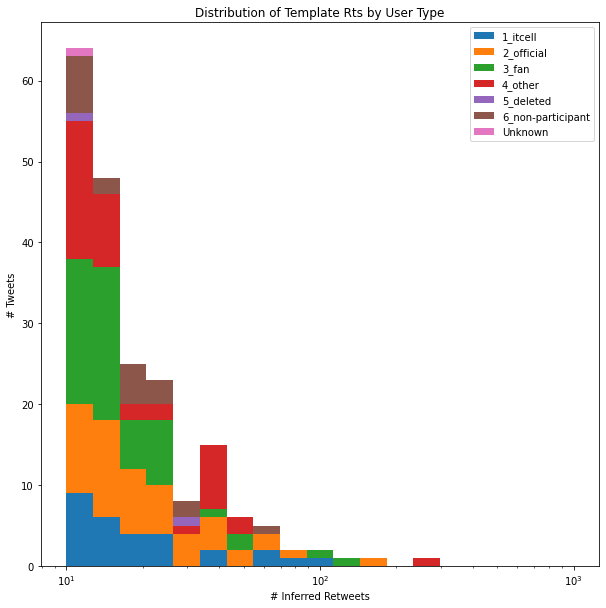

In [19]:
label_dict = summarize_top_tweets(template_rts)#trweets)
keys, values = list(label_dict.keys()), list(label_dict.values())
sorted_keys, sorted_values = zip(*sorted(zip(keys, values), key=lambda x: x[0]))

plt.figure(figsize=(10,10))
logbins = np.geomspace(10, 1000, 20)
plt.hist(sorted_values, stacked=True, label=sorted_keys, bins=logbins)#, density=True)
plt.legend()
plt.xscale('log')
plt.xlabel('# Inferred Retweets')
plt.ylabel('# Tweets')
plt.title('Distribution of Template Rts by User Type')
#plt.savefig('top_tweets_by_user.png')

In [56]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge seaborn

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    patsy:        0.5.1-py_0            conda-forge
    seaborn:      0.10.1-1              conda-forge
    seaborn-base: 0.10.1-py_1           conda-forge
    statsmodels:  0.11.1-py38h1e0a361_2 conda-forge

patsy-0.5.1-py 100% |################################| Time: 0:00:00   2.97 MB/s
seaborn-base-0 100% |################################| Time: 0:00:00  21.04 MB/s
statsmodels-0. 100% |################################| Time: 0:00:00  38.33 MB/s
seaborn-0.10.1 100% |################################| Time: 0:00:00 692.81 kB/s
